In [1]:
# notebook for viewing BraidedSP product and analyzing slopes in parallel (manually selected) channels

In [2]:
# ------------------------------ IMPORT LIBRARIES ------------------------------

import geopandas as gpd
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import sys
#sys.path.append(r"D:\work\scripts")
sys.path.append("D:/work/scripts")
from osgeo import gdal
import rasterio
import procBraided as pc
import skeletonize_func as skel
from shapely.geometry import LineString, Point
from skimage.morphology import label, binary_dilation

# RiverSP processing
from shapely.geometry import MultiPoint, shape
import shapely

In [3]:
# ------------------------------ STATICS ------------------------------

featureName = 'brahmaputra'
hemi='north'
tileID = '258_112L'
datadir = "D:/work/SWOTC/"+featureName+"/PIXC/"
wdir = "D:/work/SWOTbraided/scripts/"
odir = datadir+"extracted/"
figdir = "D:/work/SWOTbraided/figs/"+featureName
cldir = glob.glob("D:/work/SWORD/v16/"+featureName+"/*full*.shp")[0]
print(cldir)
isExist = os.path.exists(odir)
if not isExist:
    os.makedirs(odir)


LFmonths = [1,2,3,4,5,11,12]
HFmonths = [6,7,8,9,10]

D:/work/SWORD/v16/brahmaputra\brahmaputra_full.shp


In [4]:
# ---------------------------- Load in SWORD centerline ----------------------------
cldir = glob.glob("D:/work/SWORD/v16/"+featureName+"/*full*.shp")[0]
cl = gpd.read_file(cldir)
cl = cl.to_crs('EPSG:4326')
sword_cl_gdf, sword_cline, sword_cl_points = pc.sort_SWORD_cl(cl,showPlots=False) # Output is gdf

reachIDs = sword_cl_gdf.reachID
reachIDs

# Load in SWORD centerline of b1...
cldirb1 = glob.glob("D:/work/SWORD/v16/"+featureName+"/*b1*.shp")[0]
clb1 = gpd.read_file(cldirb1)
clb1 = clb1.to_crs('EPSG:4326')
sword_cl_gdf_b1, sword_cline_b1, sword_cl_points_b1 = pc.sort_SWORD_cl(clb1,showPlots=False) # Output is gdf
sword_cl_gdf_b1

reachIDs_b1 = sword_cl_gdf_b1.reachID
reachIDs_b1


# Load in SWORD centerline of b2...
cldirb2 = glob.glob("D:/work/SWORD/v16/"+featureName+"/*b2*.shp")[0]
clb2 = gpd.read_file(cldirb2)
clb2 = clb2.to_crs('EPSG:4326')
sword_cl_gdf_b2, sword_cline_b2, sword_cl_points_b2 = pc.sort_SWORD_cl(clb2,showPlots=False) # Output is gdf
sword_cl_gdf_b2

reachIDs_b2 = sword_cl_gdf_b2.reachID
reachIDs_b2
# b2 == right branch


# manual left branch
cldir_l= glob.glob("D:/work/SWORD/v16/"+featureName+"/*left*.shp")[0]
clbl = gpd.read_file(cldir_l)
clbl = clbl.to_crs('EPSG:4326')
#sword_cl_gdf_bl, sword_cline_bl, sword_cl_points_bl = pc.sort_SWORD_cl(clbl,showPlots=False) # Output is gdf

# manual right branch
cldir_r= glob.glob("D:/work/SWORD/v16/"+featureName+"/*right*.shp")[0]
clbr = gpd.read_file(cldir_r)
clbr = clbl.to_crs('EPSG:4326')
#sword_cl_gdf_br, sword_cline_br, sword_cl_points_br = pc.sort_SWORD_cl(clbr,showPlots=False) # Output is gdf


In [5]:
# Load in (PODAAC) RiverSP files for set1, LF and HF
from tqdm import tqdm


filenames = glob.glob('D:/work/SWOTC/brahmaputra/RiverSP/*.zip')
filenames

selfiles = [
 'D:/work/SWOTC/brahmaputra/RiverSP/SWOT_L2_HR_RiverSP_Node_010_258_AS_20240203T045247_20240203T045258_PIC0_01.zip',
 'D:/work/SWOTC/brahmaputra/RiverSP/SWOT_L2_HR_RiverSP_Node_010_273_AS_20240203T180043_20240203T180053_PIC0_01.zip',
 'D:/work/SWOTC/brahmaputra/RiverSP/SWOT_L2_HR_RiverSP_Node_018_258_AS_20240719T025323_20240719T025334_PIC0_01.zip',
 'D:/work/SWOTC/brahmaputra/RiverSP/SWOT_L2_HR_RiverSP_Node_018_273_AS_20240719T160119_20240719T160130_PIC0_03.zip']

# Read all files and trim to bbox (shapefile...)
bbox = gpd.read_file('D:/work/SWOTbraided/tile_258_112L_boundary.shp')



coords = bbox.get_coordinates()
minlat = np.min(coords.y)
maxlat = np.max(coords.y)
minlon = np.min(coords.x)
maxlon = np.max(coords.x)

rivbox = (minlon, minlat, maxlon, maxlat)

gdflist = list()
for shp in tqdm(selfiles):
    temp = gpd.read_file(shp,bbox=rivbox)
    temp = temp.loc[temp['reach_id'].isin(reachIDs_b1.apply(str))]
    gdflist.append(temp)

print('Combining files into one geodataframe...')
#shp_files = [gpd.read_file(shp) for shp in filenames]
gdf_filt = pd.concat(gdflist)
print('Done!')

gdf_filt['dist'] = pc.projectToCenterline(clbr, gdf_filt, hemi)
# gdf_filt


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

Combining files into one geodataframe...
Done!


In [6]:
print('Found '+str(len(gdf_filt))+' nodes in the provided reaches.')

gdf_filt.mask((gdf_filt.wse == -999999999999.0),inplace=True)
#gdf_filt.mask((gdf_filt.node_q == 3),inplace=True) # Filter bad quality nodes
#gdf_filt.mask((gdf_filt.node_q == 2),inplace=True) # Filter bad quality nodes
gdf_filt = gdf_filt.dropna() 
print(''+str(len(gdf_filt))+' nodes after filtering.')
gdf_filt['Datetime'] = pd.to_datetime(gdf_filt['time_str'])
gdf_filt['month'] = gdf_filt['Datetime'].dt.month
# plt.scatter(gdf_filt.dist/1000,gdf_filt.wse,c=gdf_filt.month)
# plt.rcParams['axes.spines.left'] = True
# plt.rcParams['axes.spines.right'] = True
# plt.rcParams['axes.spines.top'] = True
# plt.rcParams['axes.spines.bottom'] = True
# gdf_filt


Found 254 nodes in the provided reaches.
223 nodes after filtering.


In [7]:
# branch 2
gdflist = list()
for shp in tqdm(selfiles):
    temp = gpd.read_file(shp,bbox=rivbox)
    temp = temp.loc[temp['reach_id'].isin(reachIDs_b2.apply(str))]
    gdflist.append(temp)

print('Combining files into one geodataframe...')
#shp_files = [gpd.read_file(shp) for shp in filenames]
gdf_filt_b2 = pd.concat(gdflist)
print('Done!')

gdf_filt_b2['dist'] = pc.projectToCenterline(clbl, gdf_filt_b2, hemi)
# gdf_filt_b2

100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

Combining files into one geodataframe...
Done!


In [8]:
print('Found '+str(len(gdf_filt_b2))+' nodes in the provided reaches.')

gdf_filt_b2.mask((gdf_filt_b2.wse == -999999999999.0),inplace=True)
#gdf_filt.mask((gdf_filt.node_q == 3),inplace=True) # Filter bad quality nodes
#gdf_filt.mask((gdf_filt.node_q == 2),inplace=True) # Filter bad quality nodes
gdf_filt_b2 = gdf_filt_b2.dropna() 
print(''+str(len(gdf_filt_b2))+' nodes after filtering.')
gdf_filt_b2['Datetime'] = pd.to_datetime(gdf_filt_b2['time_str'])
gdf_filt_b2['month'] = gdf_filt_b2['Datetime'].dt.month
# plt.scatter(gdf_filt_b2.dist/1000,gdf_filt_b2.wse,c=gdf_filt_b2.month)
# plt.rcParams['axes.spines.left'] = True
# plt.rcParams['axes.spines.right'] = True
# plt.rcParams['axes.spines.top'] = True
# plt.rcParams['axes.spines.bottom'] = True
# gdf_filt_b2

Found 146 nodes in the provided reaches.
133 nodes after filtering.


In [9]:
pixcdate = '20240203'
month = int(pixcdate[4:6])
sub_rsp = gdf_filt[gdf_filt.month == int(pixcdate[4:6])]

# plt.scatter(sub_rsp['dist']/1000, sub_rsp['wse'], alpha=1,s=5,c='black',label='RiverSP-b1')

In [10]:
riverSP_files = glob.glob(odir+'riverSP_out/'+tileID+'/*_riverSP.geojson')
riverSP_files

selFiles = ['D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240203_riverSP.geojson',
 'D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240719_riverSP.geojson']


Runnning braided river analysis for: 20240203
['D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_NDWI_0224.tif', 'D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_RGB_0224.tif', 'D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_colorNDWIrb_0224.tif']
Closest mask date: 0224


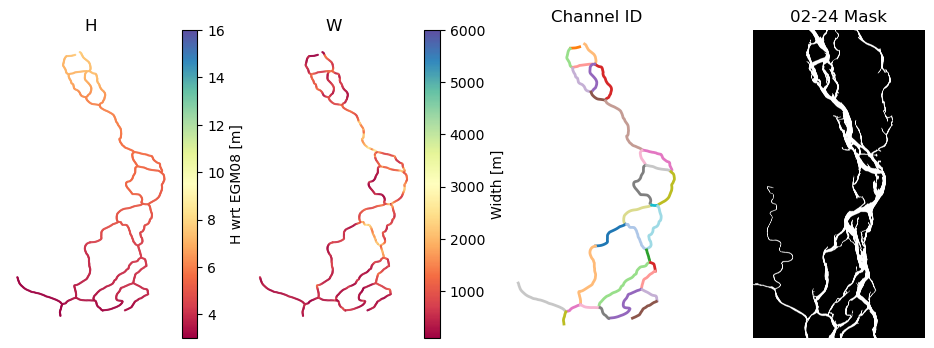

Runnning braided river analysis for: 20240719
[]
Closest mask date: 0924


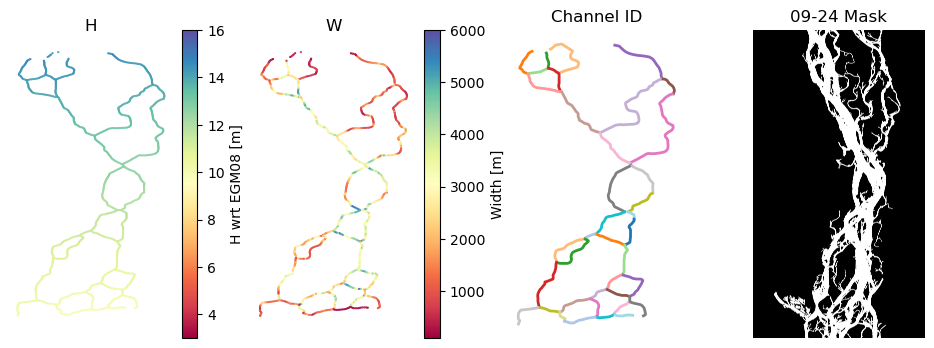

In [11]:
# ------------------------------ PLOT ALL RiverSP dates ------------------------------

for filename in selFiles:

    pixcdate = os.path.basename(filename)[0:8]

    print('Runnning braided river analysis for:',str(pixcdate))
    maskdate, water_mask_tiff = pc.getNearestMaskDate(pixcdate, tileID, LFmonths, HFmonths)

    # Load RiverSP product, water mask, and plot
    riversp_test = gpd.read_file(odir+'riverSP_out/'+tileID+'/'+pixcdate+'_riverSP.geojson')
    riversp_test = riversp_test.to_crs('EPSG:4326')
    #riversp_test = riversp_test.to_crs('EPSG:3857')  # Example of a projected UTM CRS



    # LOAD IN MASK (dilate, take largest piece)
    water_mask_tiff = glob.glob("D:/work/water_masks/brahmaputra/"+tileID+"/S2*"+str(maskdate)+".tif")[0]
    water_mask = skel.get_watermask(water_mask_tiff)
    dilated_mask = binary_dilation(water_mask, footprint=skel.createKernel(5)) # OG 10
    labeled_mask, num_features = label(dilated_mask, return_num=True)
    component_sizes = np.bincount(labeled_mask.ravel())
    component_sizes[0] = 0
    largest_component_mask = (labeled_mask == component_sizes.argmax())


    # display results and save to figure (vmin and vmax set based on 02-03-2024 and 07-19-2024)
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    ax = axes.ravel()

    # plot watermask at end
    ax[3].imshow(largest_component_mask,cmap=plt.cm.gray)
    ax[3].set_title(maskdate[0:2]+'-'+maskdate[2:4]+' Mask')
    ax[3].axis('off')


    riversp_test.plot(ax=ax[0],column='heightEGM_med',s=0.3,legend=True,legend_kwds={'label': 'H wrt EGM08 [m]'},vmin=3, vmax=16,cmap='Spectral')
    ax[0].set_title('H')
    ax[0].axis('off')
    # set aspect based on mask image
    asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
    asp /= np.abs(np.diff(ax[3].get_xlim())[0] / np.diff(ax[3].get_ylim())[0])
    ax[0].set_aspect(asp)



    riversp_test.plot(ax=ax[1],column='width',s=0.3,legend=True,legend_kwds={'label': 'Width [m]'},vmin=100, vmax=6000,cmap='Spectral')
    ax[1].set_title('W')
    ax[1].axis('off')
    # set aspect based on mask image
    asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
    asp /= np.abs(np.diff(ax[3].get_xlim())[0] / np.diff(ax[3].get_ylim())[0])
    ax[1].set_aspect(asp)


    colors = plt.cm.tab20(np.linspace(0, 1, 20))  # tab20 has 20 colors
    color_map = {branch_id: colors[i % 20] for i, branch_id in enumerate(np.arange(1,45))}

    #riversp_test.plot(column='channelID',cmap=color_map,s=0.1,legend=True,legend_kwds={'label': 'ChannelID'})

    for channelID in np.unique(riversp_test.channelID):
        sub = riversp_test.loc[riversp_test.channelID == channelID]
        color = color_map[channelID]
        ax[2].plot(sub.get_coordinates().x,sub.get_coordinates().y,color=color,linewidth=2,label=f"Branch {channelID}")

    # for _, row in riversp_test.iterrows():
    #     color = color_map[row['channelID']]
    #     ax[2].plot(*row.geometry.xy, color=color, linewidth=2, label=f"Branch {row['channelID']}")

    #riversp_test.plot(ax=ax[2],column='channelID',s=0.1,legend=True,legend_kwds={'label': 'ChannelID'},vmin=0, vmax=42)
    ax[2].set_title('Channel ID')
    ax[2].axis('off')
    # set aspect based on mask image
    asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
    asp /= np.abs(np.diff(ax[3].get_xlim())[0] / np.diff(ax[3].get_ylim())[0])
    ax[2].set_aspect(asp)


    #fig.suptitle('RiverSP '+str(pixcdate))

    isExist = os.path.exists('../figs/')
    if not isExist:
        os.makedirs('../figs/')
    plt.savefig('../figs/'+str(pixcdate)+'_gen_riverSP.png')
    plt.show()


In [12]:
# ### With improved scale

# import matplotlib.cm as cm
# import matplotlib.colors as mcolors
# for filename in selFiles:

#     pixcdate = os.path.basename(filename)[0:8]

#     print('Runnning braided river analysis for:',str(pixcdate))
#     maskdate, water_mask_tiff = pc.getNearestMaskDate(pixcdate, tileID, LFmonths, HFmonths)

#     # Load RiverSP product, water mask, and plot
#     riversp_test = gpd.read_file(odir+'riverSP_out/'+tileID+'/'+pixcdate+'_riverSP.geojson')
#     riversp_test = riversp_test.to_crs('EPSG:4326')
#     #riversp_test = riversp_test.to_crs('EPSG:3857')  # Example of a projected UTM CRS



#     # LOAD IN MASK (dilate, take largest piece)
#     water_mask_tiff = glob.glob("D:/work/water_masks/brahmaputra/"+tileID+"/S2*"+str(maskdate)+".tif")[0]
#     water_mask = skel.get_watermask(water_mask_tiff)
#     dilated_mask = binary_dilation(water_mask, footprint=skel.createKernel(5)) # OG 10
#     labeled_mask, num_features = label(dilated_mask, return_num=True)
#     component_sizes = np.bincount(labeled_mask.ravel())
#     component_sizes[0] = 0
#     largest_component_mask = (labeled_mask == component_sizes.argmax())



#     heights = riversp_test.heightEGM_med.to_numpy()
#     heights

#     widths = riversp_test.width.to_numpy()
#     cID = riversp_test.channelID.to_numpy()
#     wm_copy = np.zeros_like(water_mask)


#     fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
#     ax = axes.ravel()

#     plt.rcParams['axes.spines.left'] = False
#     plt.rcParams['axes.spines.right'] = False
#     plt.rcParams['axes.spines.top'] = False
#     plt.rcParams['axes.spines.bottom'] = False

#     ax[0].imshow(wm_copy, cmap=plt.cm.gray_r)
#     coords_df = riversp_test.get_coordinates()
#     cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
#     ax[0].scatter(cl_pixel_coords.x,cl_pixel_coords.y,c=heights,s=0.5, vmin=3, vmax=16,cmap='Spectral')
#     # Create a colorbar
#     cbar = fig.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=3, vmax=16), cmap='Spectral'), ax=ax[0], shrink=0.75)
#     cbar.set_label("Height wrt. EGM08 [m]",fontsize=12)
#     cbar.ax.tick_params(labelsize=12)
#     ax[0].set_xticks([])
#     ax[0].set_yticks([])
#     #ax[0].set_title('H')


#     ax[1].imshow(wm_copy, cmap=plt.cm.gray_r)
#     coords_df = riversp_test.get_coordinates()
#     cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
#     ax[1].scatter(cl_pixel_coords.x,cl_pixel_coords.y,c=widths,s=0.5, vmin=100, vmax=6000,cmap='Spectral')
#     # Create a colorbar
#     cbar = fig.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=100, vmax=6000), cmap='Spectral'), ax=ax[1], shrink=0.75)
#     cbar.set_label("Width [m]",fontsize=12)
#     cbar.ax.tick_params(labelsize=12)
#     ax[1].set_xticks([])
#     ax[1].set_yticks([])
#     #ax[1].set_title('W')

#     colors = plt.cm.tab20(np.linspace(0, 1, 20))  # tab20 has 20 colors
#     color_map = {branch_id: colors[i % 20] for i, branch_id in enumerate(np.arange(1,45))}

#     ax[2].imshow(wm_copy, cmap=plt.cm.gray_r)
#     coords_df = riversp_test.get_coordinates()
#     cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)

#     for channelID in np.unique(riversp_test.channelID):
#         sub = riversp_test.loc[riversp_test.channelID == channelID]
#         color = color_map[channelID]
#         coords_df = sub.get_coordinates()
#         cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
#         ax[2].plot(cl_pixel_coords.x,cl_pixel_coords.y,color=color,linewidth=2)

#     # Create a colorbar
#     cbar = fig.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=3, vmax=16), cmap='Spectral'), ax=ax[2], shrink=0.75, alpha=0)
#     #cbar.set_label("Height")
#     cbar.ax.set_visible(False)  # Hides the entire colorbar, but keeps space

#     ax[2].set_xticks([])
#     ax[2].set_yticks([])
#     ax[2].set_title('Channel ID',fontsize=15)


#     ax[3].imshow(water_mask, cmap=plt.cm.gray)
#     ax[3].set_xticks([])
#     ax[3].set_yticks([])
#     ax[3].set_title(maskdate[0:2]+'-'+maskdate[2:4]+' Mask',fontsize=15)
#     cbar = fig.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=3, vmax=16), cmap='Spectral'), ax=ax[3], shrink=0.75, alpha=0)
#     cbar.ax.set_visible(False)  # Hides the entire colorbar, but keeps space


#     #fig.suptitle('RiverSP '+str(pixcdate))

#     isExist = os.path.exists('../figs/')
#     if not isExist:
#         os.makedirs('../figs/')
#     plt.savefig('../figs/'+str(pixcdate)+'_gen_riverSP.png')
#     plt.show()

In [13]:
# # water_mask = skel.get_watermask(water_mask_tiff)
# # fig, ax = plt.subplots(figsize=(3, 6))

# # # water mask
# # ax.imshow(water_mask, cmap=plt.cm.gray)
# # # entire skeleton
# # coords_df = cl_gen.get_coordinates()
# # cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
# # ax.scatter(cl_pixel_coords.x,cl_pixel_coords.y,color='red',s=0.2)

# # test
# import matplotlib.cm as cm
# import matplotlib.colors as mcolors

# heights = riversp_test.heightEGM_med.to_numpy()
# heights

# widths = riversp_test.width.to_numpy()
# cID = riversp_test.channelID.to_numpy()
# wm_copy = np.zeros_like(water_mask)


# fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
# ax = axes.ravel()

# ax[0].imshow(wm_copy, cmap=plt.cm.gray_r)
# coords_df = riversp_test.get_coordinates()
# cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
# ax[0].scatter(cl_pixel_coords.x,cl_pixel_coords.y,c=heights,s=0.5, vmin=3, vmax=16,cmap='Spectral')
# # Create a colorbar
# cbar = fig.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=3, vmax=16), cmap='Spectral'), ax=ax[0], shrink=0.75)
# cbar.set_label("Height")
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# ax[0].set_title('H')
# plt.rcParams['axes.spines.left'] = False
# plt.rcParams['axes.spines.right'] = False
# plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.spines.bottom'] = False

# ax[1].imshow(wm_copy, cmap=plt.cm.gray_r)
# coords_df = riversp_test.get_coordinates()
# cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
# ax[1].scatter(cl_pixel_coords.x,cl_pixel_coords.y,c=widths,s=0.5, vmin=100, vmax=6000,cmap='Spectral')
# # Create a colorbar
# cbar = fig.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=100, vmax=6000), cmap='Spectral'), ax=ax[1], shrink=0.75)
# cbar.set_label("Width")
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# ax[1].set_title('W')

# colors = plt.cm.tab20(np.linspace(0, 1, 20))  # tab20 has 20 colors
# color_map = {branch_id: colors[i % 20] for i, branch_id in enumerate(np.arange(1,45))}

# ax[2].imshow(wm_copy, cmap=plt.cm.gray_r)
# coords_df = riversp_test.get_coordinates()
# cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)

# for channelID in np.unique(riversp_test.channelID):
#     sub = riversp_test.loc[riversp_test.channelID == channelID]
#     color = color_map[channelID]
#     coords_df = sub.get_coordinates()
#     cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
#     ax[2].plot(cl_pixel_coords.x,cl_pixel_coords.y,color=color,linewidth=2)

# # Create a colorbar
# cbar = fig.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=3, vmax=16), cmap='Spectral'), ax=ax[2], shrink=0.75, alpha=0)
# #cbar.set_label("Height")
# cbar.ax.set_visible(False)  # Hides the entire colorbar, but keeps space

# ax[2].set_xticks([])
# ax[2].set_yticks([])
# ax[2].set_title('Channel ID')


# ax[3].imshow(water_mask, cmap=plt.cm.gray)
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# ax[3].set_title('09-24 Mask')
# cbar = fig.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=3, vmax=16), cmap='Spectral'), ax=ax[3], shrink=0.75, alpha=0)
# cbar.ax.set_visible(False)  # Hides the entire colorbar, but keeps space

# #ax.scatter(cl_pixel_coords.x,cl_pixel_coords.y,c=cID,s=0.5, cmap=color_map)
# # print(riversp_test)

In [14]:
# Set x and y limits on lat/lon plots based on the respective coordinates from the pixel image
import rasterio
def pixel_coordinates2latlon(geotiff_path, pixel_y, pixel_x):
    # - Function to convert image coordinates to latitude and longitude

    pixel_coords = np.column_stack((pixel_y, pixel_x))

    with rasterio.open(geotiff_path) as dataset:
        latlon_coords = np.array([dataset.xy(row, col) for row, col in pixel_coords])

    df = pd.DataFrame({
        'latitude': latlon_coords[:, 1],  # latitude is the second item in (x, y) output from dataset.xy
        'longitude': latlon_coords[:, 0], # longitude is the first item in (x, y)
    })

    points = [tuple(x) for x in df[['longitude', 'latitude']].to_numpy()]

    return points

# ax[3].get_xlim()

# ax[3].get_ylim()

['D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_NDWI_0224.tif', 'D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_RGB_0224.tif', 'D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_colorNDWIrb_0224.tif']
Closest mask date: 0224


(np.float64(89.64711746840315),
 np.float64(89.83358716177746),
 np.float64(24.01122249748804),
 np.float64(24.682666760732328))

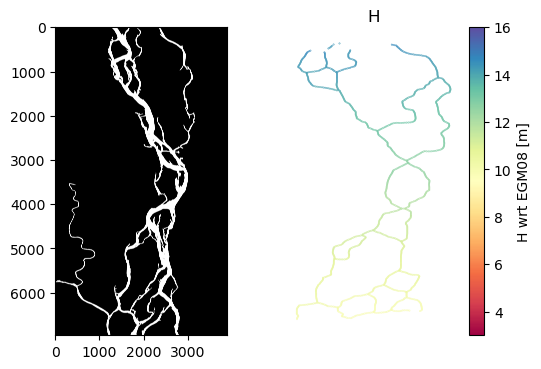

In [15]:
maskdate, water_mask_tiff = pc.getNearestMaskDate('20240203', tileID, LFmonths, HFmonths)
water_mask_tiff = glob.glob("D:/work/water_masks/brahmaputra/"+tileID+"/S2*"+str(maskdate)+".tif")[0]
water_mask = skel.get_watermask(water_mask_tiff)
dilated_mask = binary_dilation(water_mask, footprint=skel.createKernel(5)) # OG 10
labeled_mask, num_features = label(dilated_mask, return_num=True)
component_sizes = np.bincount(labeled_mask.ravel())
component_sizes[0] = 0
largest_component_mask = (labeled_mask == component_sizes.argmax())

# Get aspect of water mask
fig, (ax, ax2) = plt.subplots(figsize=(6, 4),ncols=2)

ax.imshow(largest_component_mask,cmap=plt.cm.gray)
riversp_test.plot(ax=ax2,column='heightEGM_med',s=0.1,legend=True,legend_kwds={'label': 'H wrt EGM08 [m]'},vmin=3, vmax=16,cmap='Spectral')


asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0] # get aspect of new plot
asp /= np.abs(np.diff(ax.get_xlim())[0] / np.diff(ax.get_ylim())[0]) #resize to image
ax2.set_aspect(asp)
ax2.set_title('H')
ax2.axis('off')


# # display results and save to figure (vmin and vmax set based on 02-03-2024 and 07-19-2024)
# fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
# ax = axes.ravel()


# riversp_test.plot(ax=ax[0],column='heightEGM_med',s=0.1,legend=True,legend_kwds={'label': 'H wrt EGM08 [m]'},vmin=3, vmax=16,cmap='Spectral')
# ax[0].set_title('H')
# ax[0].axis('off')
# ax[0].set_aspect(asp)

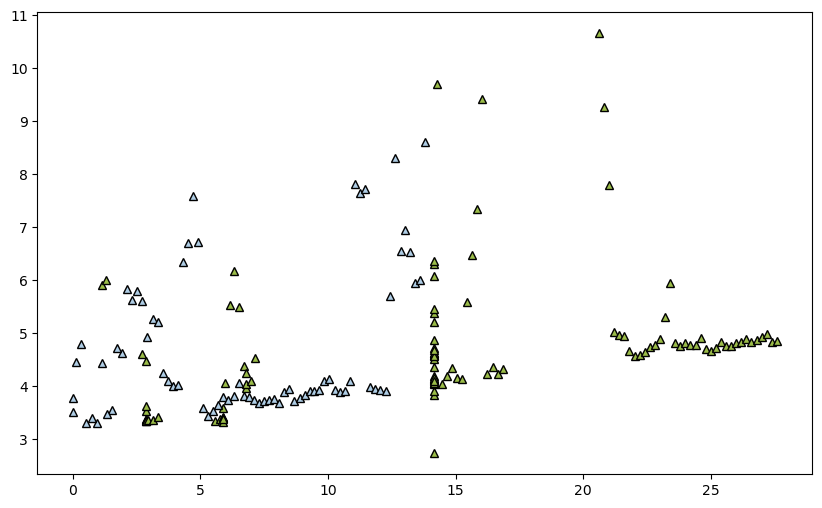

In [16]:
pixcdate = '20240203'
#ax.scatter(swot_pixc_ch1['dist_jointCL']/1000, swot_pixc_ch1['heightEGM'], alpha=0.4, c='#9BBC49', s=0.7, label='CH. 1 PIXC')
#ax.scatter(swot_pixc_ch2['dist_jointCL']/1000, swot_pixc_ch2['heightEGM'], alpha=0.4, c='#AECCE4', s=0.7, label='CH. 2 PIXC') # old #D3D3D3

fig, ax = plt.subplots(figsize=(10, 6))
sub_rsp = gdf_filt[gdf_filt.month == int(pixcdate[4:6])]
ax.plot(sub_rsp['dist']/1000, sub_rsp['wse'], alpha=1,linestyle='',markersize=6,marker='^',markeredgecolor='black',c='#9BBC49',label='RiverSP-C1')

sub_rsp_b2 = gdf_filt_b2[gdf_filt_b2.month == int(pixcdate[4:6])]
ax.plot(sub_rsp_b2['dist']/1000, sub_rsp_b2['wse'], alpha=1,linestyle='',markersize=6,marker='^',markeredgecolor='black',c='#AECCE4',label='RiverSP-C2')


Runnning braided river analysis for: 20240203
['D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_NDWI_0224.tif', 'D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_RGB_0224.tif', 'D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_colorNDWIrb_0224.tif']
Closest mask date: 0224
maskdate: 0224
reading in file: D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240203_riverSP.geojson
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT RiverSP to joint centerline...
Projected!
Checking slope...
Extracting centerline from cl gdf... (merging and sorting)


C:\Users\cwch\AppData\Local\Temp\ipykernel_30056\1791735125.py:152: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[22709.91372737 22909.91372737 23109.91372737 23309.91372737
 23509.91372737 23709.91372737 23909.91372737 24109.91372737
 24309.91372737 24509.91372737 24709.91372737 24909.91372737
 25109.91372737 25309.91372737 25509.91372737 25709.91372737
 25909.91372737 26109.91372737 26309.91372737 26509.91372737
 26709.91372737 26909.91372737 27109.91372737 27309.91372737
 27509.91372737 27709.91372737 27909.91372737 28109.91372737
 28309.91372737 28509.91372737 28709.91372737 28909.91372737
 29109.91372737 29309.91372737 29509.91372737 29709.91372737
 29909.91372737 30109.91372737 19523.0057808  19723.0057808
 19923.0057808  20123.0057808  20323.0057808  20523.0057808
 20723.0057808  20923.0057808  21123.0057808  21323.0057808
 21523.0057808  21723.0057808  21923.0057808  22123.0057808
 22323.0057808

Projecting SWOT RiverSP to joint centerline...
Projected!
Checking slope...
Reading in SWOT PIXC data....
Reading in SWOT PIXC data....
Reading in SWOT PIXC data....
Reading in SWOT PIXC data....
Reading in SWOT PIXC data....
Projecting SWOT PIXC data (CH1) to joint centerline...
Reading in SWOT PIXC data....
Reading in SWOT PIXC data....
Reading in SWOT PIXC data....
Reading in SWOT PIXC data....
Projecting SWOT PIXC data (CH2) to joint centerline...
node_q
1.0    92
3.0    13
0.0     3
2.0     1
Name: count, dtype: int64
node_q
1.0    61
3.0    11
Name: count, dtype: int64


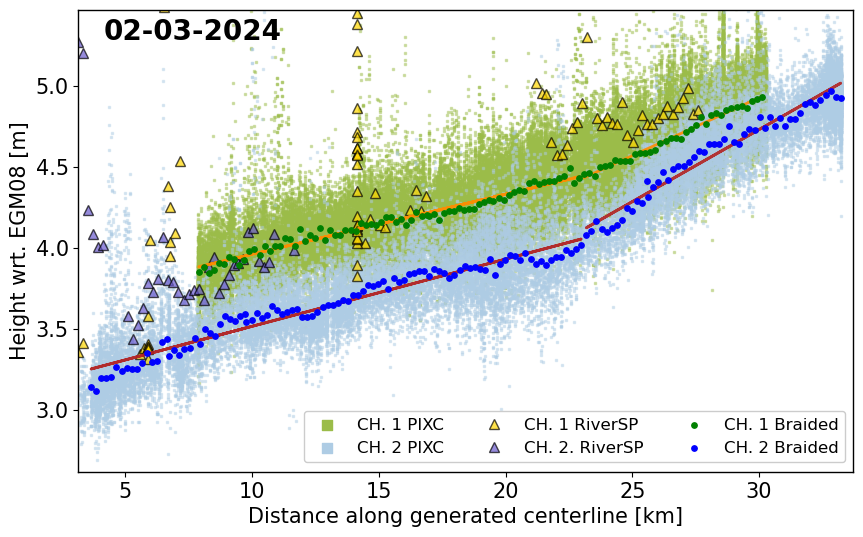

Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)


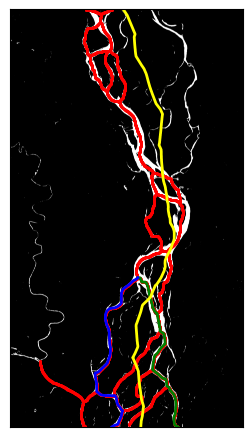

Runnning braided river analysis for: 20240719
[]
Closest mask date: 0924
maskdate: 0924
reading in file: D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240719_riverSP.geojson
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT RiverSP to joint centerline...
Projected!
Checking slope...
Slope negative! Flipping centerline and re-projecting...
Projected!
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT RiverSP to joint centerline...
Projected!
Checking slope...
Reading in SWOT PIXC data....


C:\Users\cwch\AppData\Local\Temp\ipykernel_30056\1791735125.py:152: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 4375.22840803  4175.22840803  3975.22840803  3775.22840803
  3575.22840803  3375.22840803  3175.22840803  2975.22840802
  2775.22840802  2575.22840803  2375.22840802  2175.22840802
  1975.22840802  1775.22840802  1575.22840803  1375.22840802
  1175.22840802   975.22840802   775.22840802   575.22840803
   375.22840802   175.22840802 11850.89997558 11650.89997558
 11450.89997558 11250.89997558 11050.89997558 10850.89997558
 10650.89997558 10450.89997558 10250.89997558 10050.89997558
  9850.89997558  9650.89997558  9450.89997558  9250.89997558
  9050.89997558  8850.89997558  8650.89997558  8450.89997558
  8250.89997558  8050.89997558  7850.89997558  7650.89997558
  7450.89997558  7250.89997558  7050.89997558  6850.89997558
  6650.89997558  6450.89997558  6250.89997558  6050.89997558
  5850.899

Reading in SWOT PIXC data....
Reading in SWOT PIXC data....
Reading in SWOT PIXC data....
Reading in SWOT PIXC data....
Projecting SWOT PIXC data (CH1) to joint centerline...
Reading in SWOT PIXC data....
Reading in SWOT PIXC data....
Reading in SWOT PIXC data....
Reading in SWOT PIXC data....
Reading in SWOT PIXC data....
Projecting SWOT PIXC data (CH2) to joint centerline...
node_q
2.0    114
Name: count, dtype: int64
node_q
2.0    61
Name: count, dtype: int64


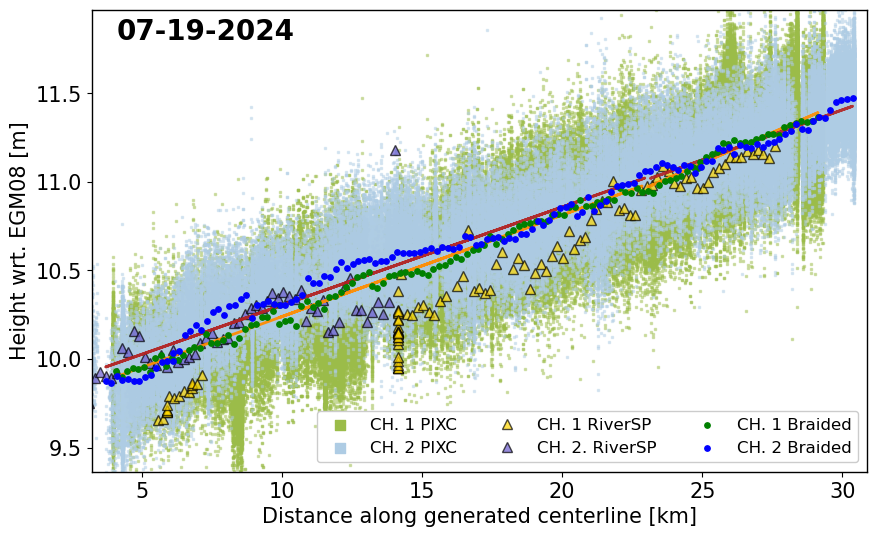

Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)


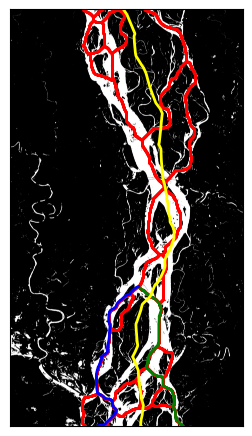

In [ ]:
# PLOT just the one needed for the paper.....

# ------------------------------ PLOT selected channels for HF and LF ------------------------------



from sklearn.linear_model import LinearRegression

# LARGE CHANNELS (entire)
# channel1_dict = dict({'0224':['1','4','8','10','11','12','14','16','17','19','18','22','25','27','28','30','32'],
#                       '0924':[]})
# channel2_dict = dict({'0224':[],
#                       '0924':[]})

allSets = ['set2','set3','set4']
allSets = ['set1','set2','set3']
allSets = ['set1']


for channelSet in allSets:

#channelSet = 'set2'

    if channelSet == 'set1':
        # SMALL main CHANNELS (parallel branches)
        channel1_dict = dict({'0224':['22','25','27','28','30','32'],
                              '0324': ['20','23','25','26','28','30'],
                            '0924':['23','26','28','31','35','41'],
                            '1024':['24','27','31','34','38']})
        channel2_dict = dict({'0224':['21','23','24','34','35','38'],
                              '0324':['21','22','32','33','36'],
                            '0924':['22','24','27','37','38','43'],
                            '1024':['23','25','29','36','41','43']})


    if channelSet == 'set1p1':
        # SMALL main CHANNELS (parallel branches)
        channel1_dict = dict({'0224':['22','25'],
                            '0924':['23','26'],
                            '1024':['24','27']})
        channel2_dict = dict({'0224':['21'],
                            '0924':['22','24'],
                            '1024':['23','25']})

    if channelSet == 'set2':
        # SMALLER CHANNELS (divide that merges in HF)
        channel1_dict = dict({'0224':['14','16'],
                              '0324': ['12','15'],
                            '0924':['14','16'],
                            '1024':['16','18']})
        channel2_dict = dict({'0224':['13'],
                              '0324':['13'],
                            '0924':['14','16'],
                            '1024':['16','18']})

    if channelSet == 'set3':
        # Meander and the straight (No1)
        channel1_dict = dict({'0224':['16','17'],
                              '0324':['15','16'],
                            '0924':['16','17'],
                            '1024': ['18','19']})
        channel2_dict = dict({'0224':['15'],
                              '0324':['14'],
                            '0924':['15'],
                            '1024': ['17']})

    if channelSet == 'set4':
        # Meander and the straight (No2)
        channel1_dict = dict({'0224':['18','22'],
                              '0324':['17','20'],
                            '0924':['19','23'],
                            '1024':['21','24']})
        channel2_dict = dict({'0224':['20'],
                              '0324':['19'],
                            '0924':['20','21'],
                            '1024':['20','22']})

    sel_riverSP = ['D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240203_riverSP.geojson','D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240719_riverSP.geojson']

    #sel_riverSP = ['D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240203_riverSP.geojson']


    for filename in sel_riverSP:

        pixcdate = os.path.basename(filename)[0:8]

        print('Runnning braided river analysis for:',str(pixcdate))
        maskdate, water_mask_tiff = pc.getNearestMaskDate(pixcdate, tileID, LFmonths, HFmonths)
        print('maskdate:',maskdate)


        # Load RiverSP product
        riversp_gdf = gpd.read_file(odir+'riverSP_out/'+tileID+'/'+pixcdate+'_riverSP.geojson')
        print('reading in file:',odir+'riverSP_out/'+tileID+'/'+pixcdate+'_riverSP.geojson')
        riversp_gdf = riversp_gdf.to_crs('EPSG:4326')

        # load generated CLs
        cl_gen = gpd.read_file(odir+tileID+'/'+maskdate+'_generated_cl.geojson')
        cl_gen = cl_gen.to_crs('EPSG:4326') 
        sword_cl_gdf = sword_cl_gdf.to_crs('EPSG:4326')

        # Selected channels
        ch1 = channel1_dict[maskdate]
        ch2 = channel2_dict[maskdate]

        ch1 = list(map(int, ch1))
        ch2 = list(map(int, ch2))
        branch_colors = ['green','blue']

        # prep data for projection along channel cl
        riversp_gdf['joint_channel_id'] = 0
        riversp_gdf['dist_jointChannel'] = 0

        for i in range(2):
            if i == 0:
                selChannels_list = ch1
            if i == 1:
                selChannels_list = ch2

            selChannels = selChannels_list #list(map(int, selChannels_list))

            print('Extracting centerline from cl gdf... (merging and sorting)')
            # get connected CL
            idb = cl_gen['branch_id'].isin(selChannels_list)
            sel_cl = cl_gen.loc[idb]

            # Fill any gaps in selected centerline and sort reaches by branch id
            sel_cl = sel_cl.reset_index(drop=True)
            merged_parts = skel.fill_cl_gaps(sel_cl,hemi,distance_threshold = 1000) # merge all main line parts
            #print('merged_parts',merged_parts)
            if isinstance(merged_parts,LineString):
                merged_line = merged_parts
            else:
                merged_line = skel.merge_multiline_with_gaps(merged_parts)   # turns final multilinestring into single linestring and bridges any large gaps between parts

            merged_line_gdf = gpd.GeoDataFrame(geometry=[merged_line],crs=sel_cl.crs)
            #print('Plotting joint channel '+str(i+1))
            #merged_line_gdf.plot()
            sorted_gdf = merged_line_gdf


            # OLD VERSION
            # merged_gdf = fill_cl_gaps(sel_cl,hemi)
            # sorted_gdf, line_sorted = sort_general_cl(merged_gdf,showPlots=False,reverse=True) # Does this need to be a single line?

            print('Projecting SWOT RiverSP to joint centerline...')
            # Select all PIXC data associated with these channels and plot projected to CL
            idx = riversp_gdf['channelID'].isin(selChannels_list)
            riversp_gdf.loc[idx, 'joint_channel_id'] = i + 1


            riversp_gdf.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(merged_line_gdf,riversp_gdf.loc[idx,['geometry']],hemi)
            #swot_pixc.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(sorted_gdf,swot_pixc.loc[idx,['geometry']],hemi)
            print('Projected!')
            #print(riversp_gdf.loc[idx])
            print('Checking slope...')
            # CHECK SLOPE - IF NEGATIVE THEN REVERSE DURING 'FILL GAPS'
            channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] == i + 1]
            regr = LinearRegression()
            regr.fit(channels_gdf[['dist_jointChannel']], channels_gdf[['heightEGM_med']])

            if np.round(regr.coef_[0][0]*1000*100,decimals=4) < 0:
                # REVERSE CENTERLINE:
                print('Slope negative! Flipping centerline and re-projecting...')
                merged_line_gdf = merged_line_gdf.reverse()
                riversp_gdf.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(merged_line_gdf,riversp_gdf.loc[idx,['geometry']],hemi)
                print('Projected!')

            if i == 0:
                merged_line_gdf_ch1 = merged_line_gdf
            if i == 1:
                merged_line_gdf_ch2 = merged_line_gdf

            
                



        ## ------------------- Project against SWORD
        riversp_gdf['dist_SWORDcl'] = pc.projectToCenterline(sword_cl_points,riversp_gdf[['geometry']],hemi)
        regr_sword = LinearRegression()
        regr_sword.fit(riversp_gdf[['dist_SWORDcl']], riversp_gdf[['heightEGM_med']])
        h_pred_sword = regr_sword.predict(riversp_gdf[['dist_SWORDcl']])

        ## ------------------- PLOT against generated centerline

        # LOAD PIXC data as well and plot with the riverSP prod...

        swot_pixc_ch1 = gpd.GeoDataFrame()
        for channel in ch1:

            swot_file = odir+'riverSP_out/'+tileID+'/'+pixcdate+'_'+str(channel)+'_subswot.geojson'
            if os.path.exists(swot_file):
                # load file and save to swot_pixc
                print('Reading in SWOT PIXC data....')
                swot_temp = gpd.read_file(swot_file)
                # Store
                swot_pixc_ch1 = pd.concat([swot_pixc_ch1,swot_temp])

        # project to CL
        print('Projecting SWOT PIXC data (CH1) to joint centerline...')
        swot_pixc_ch1['dist_jointCL'] = pc.projectToCenterline(merged_line_gdf_ch1,swot_pixc_ch1[['geometry']],hemi)



        swot_pixc_ch2 = gpd.GeoDataFrame()
        for channel in ch2:

            swot_file = odir+'riverSP_out/'+tileID+'/'+pixcdate+'_'+str(channel)+'_subswot.geojson'
            if os.path.exists(swot_file):
                # load file and save to swot_pixc
                print('Reading in SWOT PIXC data....')
                swot_temp = gpd.read_file(swot_file)
                # Store
                swot_pixc_ch2 = pd.concat([swot_pixc_ch2,swot_temp])
                
        # project to CL
        print('Projecting SWOT PIXC data (CH2) to joint centerline...')
        swot_pixc_ch2['dist_jointCL'] = pc.projectToCenterline(merged_line_gdf_ch2,swot_pixc_ch2[['geometry']],hemi)


        ##################### PLOT NO. 2 BEGINS HERE - no slopes in the corner #####################
        both_channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] != 0]

        xrange = (np.min(both_channels_gdf.dist_jointChannel)-500,np.max(both_channels_gdf.dist_jointChannel)+500)
        yrange = (np.min(both_channels_gdf.heightEGM_med)-1,np.max(both_channels_gdf.heightEGM_med)+1)
        yrange = (np.min(both_channels_gdf.heightEGM_med)-0.1,np.max(both_channels_gdf.heightEGM_med)+0.1)
        yrange = (np.min(both_channels_gdf.heightEGM_med)-0.5,np.max(both_channels_gdf.heightEGM_med)+0.5)

        ## ---------------------------------------------------------##
        ## ---------------------- 1st plot -------------------------##
        ## ---------------------------------------------------------##
        if channelSet == 'set1':
            slopes = []
            fig, ax = plt.subplots(figsize=(10, 6))
            
            ax.scatter(swot_pixc_ch1['dist_jointCL']/1000, swot_pixc_ch1['heightEGM'], alpha=0.4, marker=',', c='#9BBC49', s=1, label='CH. 1 PIXC')
            ax.scatter(swot_pixc_ch2['dist_jointCL']/1000, swot_pixc_ch2['heightEGM'], alpha=0.4, marker=',',c='#AECCE4', s=1, label='CH. 2 PIXC') # old #D3D3D3
            
            # PLOT RIVER SP 
            sub_rsp = gdf_filt[gdf_filt.month == int(pixcdate[4:6])]
            print(sub_rsp.node_q.value_counts())
            sub_rsp_node_q_high = sub_rsp.loc[sub_rsp.node_q <= 2]
            ax.plot(sub_rsp_node_q_high['dist']/1000, sub_rsp_node_q_high['wse'], alpha=0.7,linestyle='',markersize=7,marker='^',markeredgecolor='black',c='gold',label='CH. 1 RiverSP')

            sub_rsp_b2 = gdf_filt_b2[gdf_filt_b2.month == int(pixcdate[4:6])]
            print(sub_rsp_b2.node_q.value_counts())
            sub_rsp_b2_node_q_high = sub_rsp_b2.loc[sub_rsp_b2.node_q <= 2]
            ax.plot(sub_rsp_b2_node_q_high['dist']/1000, sub_rsp_b2_node_q_high['wse'], alpha=0.7,linestyle='',markersize=7,marker='^',markeredgecolor='black',c='slateblue',label='CH. 2. RiverSP')


            for joint_channel in np.unique(riversp_gdf['joint_channel_id']):

                if joint_channel == 0:
                    continue

                if joint_channel == 1:
                    slope_col = '#9BBC49'
                    slope_col = 'darkorange'
                    slope_line_type = '-'
                else:
                    slope_col = '#AECCE4'
                    slope_col = 'firebrick'
                    slope_line_type = '-'

                channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] == joint_channel]

                # Slope 1: 
                subset1 = channels_gdf[channels_gdf['dist_jointChannel'] < 23*1000]
                regr = LinearRegression()
                regr.fit(subset1[['dist_jointChannel']], subset1[['heightEGM_med']])
                h_pred = regr.predict(subset1[['dist_jointChannel']])
                ax.plot(subset1.dist_jointChannel/1000, h_pred, linewidth=2, c=slope_col, linestyle=slope_line_type, alpha=0.95)
                slope1 = np.round(regr.coef_[0][0]*1000*100,decimals=2)

                # Slope 2
                subset2 = channels_gdf[channels_gdf['dist_jointChannel'] >= 23*1000]
                regr = LinearRegression()
                regr.fit(subset2[['dist_jointChannel']], subset2[['heightEGM_med']])
                h_pred = regr.predict(subset2[['dist_jointChannel']])
                ax.plot(subset2.dist_jointChannel/1000, h_pred, linewidth=2, c=slope_col, linestyle=slope_line_type, alpha=0.9)
                slope2 = np.round(regr.coef_[0][0]*1000*100,decimals=2)
                
                # plot the braided product
                ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM_med'], alpha=1, c=branch_colors[int(joint_channel-1)], s=15.0, label='CH. '+str(int(joint_channel))+' Braided',zorder=10)


                if joint_channel == 1:
                    textH = 0.83
                else:
                    textH = 0.77


            ##################### legend #####################
            marker_size = 24
            def update_prop(handle, orig):
                handle.update_from(orig)
                handle.set_sizes([marker_size])

            from matplotlib.legend_handler import HandlerPathCollection
            import matplotlib.lines as mlines
            #if len(np.unique(riversp_gdf['joint_channel_id'])) != 2:
                #ax.legend(loc='upper center',bbox_to_anchor=(0.70, 0.15),ncol=3, markerscale=2)
                #ax.legend(loc='upper center',bbox_to_anchor=(0.70, 0.15),ncol=3, fontsize=12, handler_map={type(ax): HandlerPathCollection(update_func=update_prop)})
            
            lgd = ax.legend(loc='upper center',bbox_to_anchor=(0.64, 0.15),facecolor="white",framealpha=1,ncol=3, fontsize=12, handler_map={type(ax): HandlerPathCollection(update_func=update_prop)})

            for h, legend_handle in enumerate(lgd.legend_handles):

                if isinstance(legend_handle, mlines.Line2D):
                    continue

                if h <=1:
                    legend_handle.set_sizes([50])

                legend_handle.set_alpha(1)

            # reorger to set legend
            # paired_list = list(zip([0,1,4,5,2,3], lgd.legend_handles))
            # sorted_pairs = sorted(paired_list, key=lambda item: item[0])
            # lgd.legend_handles = [item[1] for item in sorted_pairs]


            for spine in ax.spines.values():
                spine.set_visible(True)  # Ensure the spine is visible
                spine.set_linewidth(1)   # Set the thickness of the border


            ax.set_xlabel("Distance along generated centerline [km]",fontsize=15)
            ax.set_ylabel("Height wrt. EGM08 [m]",fontsize=15)
            ax.tick_params(axis='both',which='major',labelsize=15)
            #ax.set_title(str(pixcdate))
            plt.figtext(0.15, 0.83,str(pixcdate[4:6]+'-'+pixcdate[6:8]+'-'+pixcdate[0:4]),fontweight='demi',fontsize=20)
            ax.set_xlim(xrange[0]/1000,xrange[1]/1000)
            ax.set_ylim(yrange[0],yrange[1]) # Always keeping window size of 10 m height for better slope comparison
            #plt.figtext(0.15, 0.77, f'RiverSP slope = {np.round(regr_sword.coef_[0][0]*1000*100,decimals=4)} cm/km',color='black')
            #plt.savefig('../figs/'+str(pixcdate)+'_slopes_ch_'+channelSet+'_divided.png')
            plt.savefig('../figs/'+str(pixcdate)+'_slopes_ch_'+channelSet+'_divided.png',format='png', dpi=500)
            plt.show()





            ## ---------------------------------------------------------##
            ## ------------------- PLOT selected cl ------------------- ##
            ## ---------------------------------------------------------##

            water_mask = skel.get_watermask(water_mask_tiff)
            fig, ax = plt.subplots(figsize=(3, 6))

            # water mask
            ax.imshow(water_mask, cmap=plt.cm.gray)
            
            # entire skeleton
            coords_df = cl_gen.get_coordinates()
            cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
            ax.scatter(cl_pixel_coords.x,cl_pixel_coords.y,color='red',s=0.2)
            # for _, row in cl_gen.iterrows():
            #     ax.plot(*row.geometry.xy, color='red', linewidth=2)

            for i in range(2):
                if i == 0:
                    selChannels_list = ch1
                if i == 1:
                    selChannels_list = ch2

                selChannels = selChannels_list 

                print('Extracting centerline from cl gdf... (merging and sorting)')
                # get connected CL
                idb = cl_gen['branch_id'].isin(selChannels_list)
                sel_cl = cl_gen.loc[idb]

                # Fill any gaps in selected centerline and sort reaches by branch id
                sel_cl = sel_cl.reset_index(drop=True)
                merged_parts = skel.fill_cl_gaps(sel_cl,hemi,distance_threshold = 1000) # merge all main line parts
                if isinstance(merged_parts,LineString):
                    merged_line = merged_parts
                else:
                    merged_line = skel.merge_multiline_with_gaps(merged_parts)   # turns final multilinestring into single linestring and bridges any large gaps between parts

                merged_line_gdf = gpd.GeoDataFrame(geometry=[merged_line],crs=sel_cl.crs)    

                # get line in  pixel coords
                coords_df = merged_line_gdf.get_coordinates()
                merged_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)

                # for _, row in merged_line_gdf.iterrows():
                #     ax.plot(*row.geometry.xy, color=branch_colors[int(i)], linewidth=2)

                # selected channels
                ax.plot(merged_pixel_coords.x,merged_pixel_coords.y,color=branch_colors[int(i)],linewidth=2)


            # SWORD CL
            coords_df = sword_cl_gdf.get_coordinates()
            sword_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
            ax.plot(sword_pixel_coords.x,sword_pixel_coords.y,color='yellow',linewidth=2)

            y, x = np.where((water_mask)) 
            min_x, max_x = x.min(), x.max()
            min_y, max_y = y.min(), y.max()
            ax.set_xlim(min_x, max_x)
            ax.set_ylim(max_y, min_y)

            # Set plot properties
            #ax.set_title("Selected centerlines "+str(pixcdate))
            # Remove x and y tick marks
            ax.set_xticks([])
            ax.set_yticks([])

            plt.savefig('../figs/'+str(pixcdate)+'_selected_channels_'+channelSet+'.png')
            plt.show()


For low flow:
- 0.0     3
- 1.0    92 + 61
- 2.0     1
- 3.0    13 + 11
- Total kept: 127
- Totall Removed: 24

For high flow
- 2.0    114 + 61
- Total kept: 175
- Total removed: 0

In [88]:
(92+61)/(3+92+61+1)

0.9745222929936306

In [18]:

# if channelSet == 'set1':
#     slopes = []
#     fig, ax = plt.subplots(figsize=(10, 6))
#     ax.scatter(swot_pixc_ch1['dist_jointCL']/1000, swot_pixc_ch1['heightEGM'], alpha=0.4, c='#9BBC49', s=0.7, label='CH. 1 PIXC')
#     ax.scatter(swot_pixc_ch2['dist_jointCL']/1000, swot_pixc_ch2['heightEGM'], alpha=0.4, c='#AECCE4', s=0.7, label='CH. 2 PIXC') # old #D3D3D3

#     for joint_channel in np.unique(riversp_gdf['joint_channel_id']):

#         if joint_channel == 0:
#             continue


#         if joint_channel == 1:
#             slope_col = '#9BBC49'
#             slope_col = 'purple'
#         else:
#             slope_col = '#AECCE4'
#             slope_col = 'red'

#         channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] == joint_channel]


#         # Slope 1: 
#         subset1 = channels_gdf[channels_gdf['dist_jointChannel'] < 23*1000]
#         regr = LinearRegression()
#         regr.fit(subset1[['dist_jointChannel']], subset1[['heightEGM_med']])
#         h_pred = regr.predict(subset1[['dist_jointChannel']])
#         ax.plot(subset1.dist_jointChannel/1000, h_pred,markersize=1,c=slope_col,alpha=0.6)
#         slope1 = np.round(regr.coef_[0][0]*1000*100,decimals=2)
#         # if joint_channel == 1:
#         #     ax.text(np.mean(subset1.dist_jointChannel/1000)-3.5,np.mean(h_pred)+0.2,f'{slope1} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')
#         # else:
#         #     ax.text(np.mean(subset1.dist_jointChannel/1000)-0.1,np.mean(h_pred)-0.2,f'{slope1} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')

#         # Slope 2
#         subset2 = channels_gdf[channels_gdf['dist_jointChannel'] >= 23*1000]
#         regr = LinearRegression()
#         regr.fit(subset2[['dist_jointChannel']], subset2[['heightEGM_med']])
#         h_pred = regr.predict(subset2[['dist_jointChannel']])
#         ax.plot(subset2.dist_jointChannel/1000, h_pred,markersize=1,c=slope_col,alpha=0.6)
#         slope2 = np.round(regr.coef_[0][0]*1000*100,decimals=2)
#         #if joint_channel == 1:
#             ##ax.text(np.mean(subset2.dist_jointChannel/1000)+2,np.mean(h_pred)+2,f'{slope2} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')
#             #ax.text(np.mean(subset2.dist_jointChannel/1000)-4,np.mean(h_pred)+0.1,f'{slope2} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')
#         #else:
#             #ax.text(np.mean(subset2.dist_jointChannel/1000)-0.1,np.mean(h_pred)-0.2,f'{slope2} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')
        
        
#         ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM_med'], alpha=1, c=branch_colors[int(joint_channel-1)], s=3.0, label='CH. '+str(int(joint_channel))+' BraidedSP')

#         # sub_rsp = gdf_filt.iloc[gdf_filt.month == int(pixcdate[4:6])]
#         # ax.scatter(sub_rsp['dist']/1000, sub_rsp['wse'], alpha=1,s=3,c='#FFC107',label='RiverSP-br')

#         # sub_rsp_b2 = gdf_filt_b2.iloc[gdf_filt_b2.month == int(pixcdate[4:6])]
#         # ax.scatter(sub_rsp_b2['dist']/1000, sub_rsp_b2['wse'], alpha=1,s=3,c='#004D40',label='RiverSP-bl')

#         #print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
#         #ax.plot(channels_gdf.dist_jointChannel/1000, h_pred,'.',markersize=1,c='red')
#         if joint_channel == 1:
#             textH = 0.83
#         else:
#             textH = 0.77



#     # PLOT RIVER SP 

#     sub_rsp = gdf_filt[gdf_filt.month == int(pixcdate[4:6])]
#     ax.plot(sub_rsp['dist']/1000, sub_rsp['wse'], alpha=1,linestyle='',markersize=6,marker='^',markeredgecolor='black',c='#9BBC49',label='RiverSP-C1')

#     sub_rsp_b2 = gdf_filt_b2[gdf_filt_b2.month == int(pixcdate[4:6])]
#     ax.plot(sub_rsp_b2['dist']/1000, sub_rsp_b2['wse'], alpha=1,linestyle='',markersize=6,marker='^',markeredgecolor='black',c='#AECCE4',label='RiverSP-C2')

#     ##################### legend #####################
#     marker_size = 100
#     def update_prop(handle, orig):
#         handle.update_from(orig)
#         handle.set_sizes([marker_size])

#     from matplotlib.legend_handler import HandlerPathCollection
#     import matplotlib.lines as mlines
#     #if len(np.unique(riversp_gdf['joint_channel_id'])) != 2:
#         #ax.legend(loc='upper center',bbox_to_anchor=(0.70, 0.15),ncol=3, markerscale=2)
#         #ax.legend(loc='upper center',bbox_to_anchor=(0.70, 0.15),ncol=3, fontsize=12, handler_map={type(ax): HandlerPathCollection(update_func=update_prop)})
    
#     lgd = ax.legend(loc='upper center',bbox_to_anchor=(0.65, 0.15),facecolor="white",framealpha=1,ncol=3, fontsize=12, handler_map={type(ax): HandlerPathCollection(update_func=update_prop)})

#     for legend_handle in lgd.legend_handles:
#         print(legend_handle)
#         if isinstance(legend_handle, mlines.Line2D):
#             continue
#         legend_handle.set_sizes([50])
#         legend_handle.set_alpha(1)

#     for spine in ax.spines.values():
#         spine.set_visible(True)  # Ensure the spine is visible
#         spine.set_linewidth(1)   # Set the thickness of the border


#     ax.set_xlabel("Distance along generated centerline [km]",fontsize=15)
#     ax.set_ylabel("Height wrt. EGM08 [m]",fontsize=15)
#     ax.tick_params(axis='both',which='major',labelsize=15)
#     #ax.set_title(str(pixcdate))
#     plt.figtext(0.15, 0.83,str(pixcdate[4:6]+'-'+pixcdate[6:8]+'-'+pixcdate[0:4]),fontweight='demi',fontsize=20)
#     ax.set_xlim(xrange[0]/1000,xrange[1]/1000)
#     ax.set_ylim(yrange[0],yrange[1]) # Always keeping window size of 10 m height for better slope comparison
#     #plt.figtext(0.15, 0.77, f'RiverSP slope = {np.round(regr_sword.coef_[0][0]*1000*100,decimals=4)} cm/km',color='black')
#     #plt.savefig('../figs/'+str(pixcdate)+'_slopes_ch_'+channelSet+'_divided.png')
#     plt.savefig('../figs/'+str(pixcdate)+'_slopes_ch_'+channelSet+'_divided.png',format='png', dpi=500)
#     plt.show()


In [19]:
# # ------------------------------ PLOT selected channels for HF and LF ------------------------------










# from sklearn.linear_model import LinearRegression

# # LARGE CHANNELS (entire)
# # channel1_dict = dict({'0224':['1','4','8','10','11','12','14','16','17','19','18','22','25','27','28','30','32'],
# #                       '0924':[]})
# # channel2_dict = dict({'0224':[],
# #                       '0924':[]})

# allSets = ['set2','set3','set4']
# allSets = ['set1','set2','set3']
# allSets = ['set1']


# for channelSet in allSets:

# #channelSet = 'set2'

#     if channelSet == 'set1':
#         # SMALL main CHANNELS (parallel branches)
#         channel1_dict = dict({'0224':['22','25','27','28','30','32'],
#                               '0324': ['20','23','25','26','28','30'],
#                             '0924':['23','26','28','31','35','41'],
#                             '1024':['24','27','31','34','38']})
#         channel2_dict = dict({'0224':['21','23','24','34','35','38'],
#                               '0324':['21','22','32','33','36'],
#                             '0924':['22','24','27','37','38','43'],
#                             '1024':['23','25','29','36','41','43']})


#     if channelSet == 'set1p1':
#         # SMALL main CHANNELS (parallel branches)
#         channel1_dict = dict({'0224':['22','25'],
#                             '0924':['23','26'],
#                             '1024':['24','27']})
#         channel2_dict = dict({'0224':['21'],
#                             '0924':['22','24'],
#                             '1024':['23','25']})

#     if channelSet == 'set2':
#         # SMALLER CHANNELS (divide that merges in HF)
#         channel1_dict = dict({'0224':['14','16'],
#                               '0324': ['12','15'],
#                             '0924':['14','16'],
#                             '1024':['16','18']})
#         channel2_dict = dict({'0224':['13'],
#                               '0324':['13'],
#                             '0924':['14','16'],
#                             '1024':['16','18']})

#     if channelSet == 'set3':
#         # Meander and the straight (No1)
#         channel1_dict = dict({'0224':['16','17'],
#                               '0324':['15','16'],
#                             '0924':['16','17'],
#                             '1024': ['18','19']})
#         channel2_dict = dict({'0224':['15'],
#                               '0324':['14'],
#                             '0924':['15'],
#                             '1024': ['17']})

#     if channelSet == 'set4':
#         # Meander and the straight (No2)
#         channel1_dict = dict({'0224':['18','22'],
#                               '0324':['17','20'],
#                             '0924':['19','23'],
#                             '1024':['21','24']})
#         channel2_dict = dict({'0224':['20'],
#                               '0324':['19'],
#                             '0924':['20','21'],
#                             '1024':['20','22']})

#     sel_riverSP = ['D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240203_riverSP.geojson','D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240719_riverSP.geojson']

#     #sel_riverSP = ['D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240203_riverSP.geojson']


#     for filename in sel_riverSP:

#         pixcdate = os.path.basename(filename)[0:8]

#         print('Runnning braided river analysis for:',str(pixcdate))
#         maskdate, water_mask_tiff = pc.getNearestMaskDate(pixcdate, tileID, LFmonths, HFmonths)
#         print('maskdate:',maskdate)


#         # Load RiverSP product
#         riversp_gdf = gpd.read_file(odir+'riverSP_out/'+tileID+'/'+pixcdate+'_riverSP.geojson')
#         print('reading in file:',odir+'riverSP_out/'+tileID+'/'+pixcdate+'_riverSP.geojson')
#         riversp_gdf = riversp_gdf.to_crs('EPSG:4326')

#         # load generated CLs
#         cl_gen = gpd.read_file(odir+tileID+'/'+maskdate+'_generated_cl.geojson')
#         cl_gen = cl_gen.to_crs('EPSG:4326') 
#         sword_cl_gdf = sword_cl_gdf.to_crs('EPSG:4326')

#         # Selected channels
#         ch1 = channel1_dict[maskdate]
#         ch2 = channel2_dict[maskdate]

#         ch1 = list(map(int, ch1))
#         ch2 = list(map(int, ch2))
#         branch_colors = ['green','blue']

#         # prep data for projection along channel cl
#         riversp_gdf['joint_channel_id'] = 0
#         riversp_gdf['dist_jointChannel'] = 0

#         for i in range(2):
#             if i == 0:
#                 selChannels_list = ch1
#             if i == 1:
#                 selChannels_list = ch2

#             selChannels = selChannels_list #list(map(int, selChannels_list))

#             print('Extracting centerline from cl gdf... (merging and sorting)')
#             # get connected CL
#             idb = cl_gen['branch_id'].isin(selChannels_list)
#             sel_cl = cl_gen.loc[idb]

#             # Fill any gaps in selected centerline and sort reaches by branch id
#             sel_cl = sel_cl.reset_index(drop=True)
#             merged_parts = skel.fill_cl_gaps(sel_cl,hemi,distance_threshold = 1000) # merge all main line parts
#             #print('merged_parts',merged_parts)
#             if isinstance(merged_parts,LineString):
#                 merged_line = merged_parts
#             else:
#                 merged_line = skel.merge_multiline_with_gaps(merged_parts)   # turns final multilinestring into single linestring and bridges any large gaps between parts

#             merged_line_gdf = gpd.GeoDataFrame(geometry=[merged_line],crs=sel_cl.crs)
#             #print('Plotting joint channel '+str(i+1))
#             #merged_line_gdf.plot()
#             sorted_gdf = merged_line_gdf


#             # OLD VERSION
#             # merged_gdf = fill_cl_gaps(sel_cl,hemi)
#             # sorted_gdf, line_sorted = sort_general_cl(merged_gdf,showPlots=False,reverse=True) # Does this need to be a single line?

#             print('Projecting SWOT RiverSP to joint centerline...')
#             # Select all PIXC data associated with these channels and plot projected to CL
#             idx = riversp_gdf['channelID'].isin(selChannels_list)
#             riversp_gdf.loc[idx, 'joint_channel_id'] = i + 1


#             riversp_gdf.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(merged_line_gdf,riversp_gdf.loc[idx,['geometry']],hemi)
#             #swot_pixc.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(sorted_gdf,swot_pixc.loc[idx,['geometry']],hemi)
#             print('Projected!')
#             #print(riversp_gdf.loc[idx])
#             print('Checking slope...')
#             # CHECK SLOPE - IF NEGATIVE THEN REVERSE DURING 'FILL GAPS'
#             channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] == i + 1]
#             regr = LinearRegression()
#             regr.fit(channels_gdf[['dist_jointChannel']], channels_gdf[['heightEGM_med']])

#             if np.round(regr.coef_[0][0]*1000*100,decimals=4) < 0:
#                 # REVERSE CENTERLINE:
#                 print('Slope negative! Flipping centerline and re-projecting...')
#                 merged_line_gdf = merged_line_gdf.reverse()
#                 riversp_gdf.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(merged_line_gdf,riversp_gdf.loc[idx,['geometry']],hemi)
#                 print('Projected!')

#             if i == 0:
#                 merged_line_gdf_ch1 = merged_line_gdf
#             if i == 1:
#                 merged_line_gdf_ch2 = merged_line_gdf

            
                



#         ## ------------------- Project against SWORD
#         riversp_gdf['dist_SWORDcl'] = pc.projectToCenterline(sword_cl_points,riversp_gdf[['geometry']],hemi)
#         regr_sword = LinearRegression()
#         regr_sword.fit(riversp_gdf[['dist_SWORDcl']], riversp_gdf[['heightEGM_med']])
#         h_pred_sword = regr_sword.predict(riversp_gdf[['dist_SWORDcl']])

#         ## ------------------- PLOT against generated centerline

#         # LOAD PIXC data as well and plot with the riverSP prod...

#         swot_pixc_ch1 = gpd.GeoDataFrame()
#         for channel in ch1:

#             swot_file = odir+'riverSP_out/'+tileID+'/'+pixcdate+'_'+str(channel)+'_subswot.geojson'
#             if os.path.exists(swot_file):
#                 # load file and save to swot_pixc
#                 print('Reading in SWOT PIXC data....')
#                 swot_temp = gpd.read_file(swot_file)
#                 # Store
#                 swot_pixc_ch1 = pd.concat([swot_pixc_ch1,swot_temp])

#         # project to CL
#         print('Projecting SWOT PIXC data (CH1) to joint centerline...')
#         swot_pixc_ch1['dist_jointCL'] = pc.projectToCenterline(merged_line_gdf_ch1,swot_pixc_ch1[['geometry']],hemi)





#         swot_pixc_ch2 = gpd.GeoDataFrame()
#         for channel in ch2:

#             swot_file = odir+'riverSP_out/'+tileID+'/'+pixcdate+'_'+str(channel)+'_subswot.geojson'
#             if os.path.exists(swot_file):
#                 # load file and save to swot_pixc
#                 print('Reading in SWOT PIXC data....')
#                 swot_temp = gpd.read_file(swot_file)
#                 # Store
#                 swot_pixc_ch2 = pd.concat([swot_pixc_ch2,swot_temp])
                
#         # project to CL
#         print('Projecting SWOT PIXC data (CH2) to joint centerline...')
#         swot_pixc_ch2['dist_jointCL'] = pc.projectToCenterline(merged_line_gdf_ch2,swot_pixc_ch2[['geometry']],hemi)


#         ##################### PLOT NO. 1 BEGINS HERE #####################
#         # for detemining plot xlim and ylim
#         both_channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] != 0]

#         xrange = (np.min(both_channels_gdf.dist_jointChannel)-500,np.max(both_channels_gdf.dist_jointChannel)+500)
#         yrange = (np.min(both_channels_gdf.heightEGM_med)-1,np.max(both_channels_gdf.heightEGM_med)+1)
#         yrange = (np.min(both_channels_gdf.heightEGM_med)-0.1,np.max(both_channels_gdf.heightEGM_med)+0.1)
#         yrange = (np.min(both_channels_gdf.heightEGM_med)-0.5,np.max(both_channels_gdf.heightEGM_med)+0.5)

#         slopes = []
#         fig, ax = plt.subplots(figsize=(10, 6))
#         ax.scatter(swot_pixc_ch1['dist_jointCL']/1000, swot_pixc_ch1['heightEGM'], alpha=0.4, c='#9BBC49', s=0.7, label='CH. 1 PIXC')
#         ax.scatter(swot_pixc_ch2['dist_jointCL']/1000, swot_pixc_ch2['heightEGM'], alpha=0.4, c='#AECCE4', s=0.7, label='CH. 2 PIXC') # old #D3D3D3

#         for joint_channel in np.unique(riversp_gdf['joint_channel_id']):

#             if joint_channel == 0:
#                 continue

#             if len(np.unique(riversp_gdf['joint_channel_id'])) == 2: # joint channels are the same...
#                 regr = LinearRegression()
#                 regr.fit(channels_gdf[['dist_jointChannel']], channels_gdf[['heightEGM_med']])
#                 h_pred = regr.predict(channels_gdf[['dist_jointChannel']])
#                 print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=2))+' cm/km')
#                 slopes.append(np.round(regr.coef_[0][0]*1000*100,decimals=4))
#                 ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM_med'], alpha=1, c=branch_colors[1], s=2.0, label=str(int(joint_channel)))
#                 #ax.plot(channels_gdf.dist_jointChannel/1000, h_pred,'.',markersize=1,c='red')
#                 plt.figtext(0.15, 0.77, f'CH. slope = {slopes[0]} cm/km',color=branch_colors[1])
#                 break

#             channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] == joint_channel]
#             if joint_channel == 1:
#                 medY = np.round(np.median(channels_gdf.heightEGM_med),0)

#             regr = LinearRegression()
#             regr.fit(channels_gdf[['dist_jointChannel']], channels_gdf[['heightEGM_med']])
#             h_pred = regr.predict(channels_gdf[['dist_jointChannel']])
#             print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=2))+' cm/km')
#             slopes.append(np.round(regr.coef_[0][0]*1000*100,decimals=4))
#             ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM_med'], alpha=1, c=branch_colors[int(joint_channel-1)], s=3.0, label='CH. '+str(int(joint_channel)))

#             #ax.plot(channels_gdf.dist_jointChannel/1000, h_pred,'.',markersize=1,c='red')
#             if joint_channel == 1:
#                 textH = 0.77
#             else:
#                 textH = 0.72
#             plt.figtext(0.15, textH, f'CH. {str(joint_channel)} slope = {slopes[int(joint_channel-1)]} cm/km',color=branch_colors[int(joint_channel-1)])


#         ##################### legend #####################
#         marker_size = 36
#         def update_prop(handle, orig):
#             handle.update_from(orig)
#             handle.set_sizes([marker_size])

#         from matplotlib.legend_handler import HandlerPathCollection
#         if len(np.unique(riversp_gdf['joint_channel_id'])) != 2:
#             #ax.legend(loc='upper center',bbox_to_anchor=(0.70, 0.15),ncol=3, markerscale=2)
#             ax.legend(loc='upper center',bbox_to_anchor=(0.70, 0.15),ncol=3, handler_map={type(ax): HandlerPathCollection(update_func=update_prop)})

#         #if len(np.unique(riversp_gdf['joint_channel_id'])) != 2:
#         #    ax.legend(loc='upper center',bbox_to_anchor=(0.70, 0.15),ncol=3, markerscale=5)


#         ax.set_xlabel("Distance along generated centerline [km]")
#         ax.set_ylabel("Height wrt. EGM08 [m]")
#         plt.figtext(0.15, 0.83,str(pixcdate[4:6]+'-'+pixcdate[6:8]+'-'+pixcdate[0:4]),fontweight='demi')

#         #ax.set_title('Projected along generated centerlines: '+str(pixcdate))
#         # !!!!! USE THESE ONLY ONCE YOU KNOW THE LIMITS FOR SELECTED CLs
#         both_channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] != 0]

#         xrange = (np.min(both_channels_gdf.dist_jointChannel)-500,np.max(both_channels_gdf.dist_jointChannel)+500)
#         yrange = (np.min(both_channels_gdf.heightEGM_med)-1,np.max(both_channels_gdf.heightEGM_med)+1)
#         yrange = (np.min(both_channels_gdf.heightEGM_med)-0.1,np.max(both_channels_gdf.heightEGM_med)+0.1)
#         yrange = (np.min(both_channels_gdf.heightEGM_med)-0.5,np.max(both_channels_gdf.heightEGM_med)+0.5)


#         ax.set_xlim(xrange[0]/1000,xrange[1]/1000)
#         ax.set_ylim(yrange[0],yrange[1]) # Always keeping window size of 10 m height for better slope comparison
#         plt.figtext(0.15, 0.67, f'SWORD slope = {np.round(regr_sword.coef_[0][0]*1000*100,decimals=2)} cm/km',color='black')
#         #plt.savefig('../figs/'+str(pixcdate)+'_slopes_ch_'+channelSet+'.png')
#         plt.savefig('../figs/'+str(pixcdate)+'_slopes_ch_'+channelSet+'.png', format='png', dpi=500)

#         #plt.savefig(figdir+'/'+str(pixcdate)+'_projected2jointCL.png')
#         plt.show()


#         ##################### PLOT NO. 2 BEGINS HERE - no slopes in the corner #####################
#         if channelSet == 'set1':
#             slopes = []
#             fig, ax = plt.subplots(figsize=(10, 6))
#             ax.scatter(swot_pixc_ch1['dist_jointCL']/1000, swot_pixc_ch1['heightEGM'], alpha=0.4, c='#9BBC49', s=0.7, label='CH. 1 PIXC')
#             ax.scatter(swot_pixc_ch2['dist_jointCL']/1000, swot_pixc_ch2['heightEGM'], alpha=0.4, c='#AECCE4', s=0.7, label='CH. 2 PIXC') # old #D3D3D3

#             for joint_channel in np.unique(riversp_gdf['joint_channel_id']):

#                 if joint_channel == 0:
#                     continue


#                 if joint_channel == 1:
#                     slope_col = '#9BBC49'
#                     slope_col = 'purple'
#                 else:
#                     slope_col = '#AECCE4'
#                     slope_col = 'red'

#                 channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] == joint_channel]


#                 # Slope 1: 
#                 subset1 = channels_gdf[channels_gdf['dist_jointChannel'] < 23*1000]
#                 regr = LinearRegression()
#                 regr.fit(subset1[['dist_jointChannel']], subset1[['heightEGM_med']])
#                 h_pred = regr.predict(subset1[['dist_jointChannel']])
#                 ax.plot(subset1.dist_jointChannel/1000, h_pred,markersize=1,c=slope_col,alpha=0.6)
#                 slope1 = np.round(regr.coef_[0][0]*1000*100,decimals=2)
#                 # if joint_channel == 1:
#                 #     ax.text(np.mean(subset1.dist_jointChannel/1000)-3.5,np.mean(h_pred)+0.2,f'{slope1} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')
#                 # else:
#                 #     ax.text(np.mean(subset1.dist_jointChannel/1000)-0.1,np.mean(h_pred)-0.2,f'{slope1} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')

#                 # Slope 2
#                 subset2 = channels_gdf[channels_gdf['dist_jointChannel'] >= 23*1000]
#                 regr = LinearRegression()
#                 regr.fit(subset2[['dist_jointChannel']], subset2[['heightEGM_med']])
#                 h_pred = regr.predict(subset2[['dist_jointChannel']])
#                 ax.plot(subset2.dist_jointChannel/1000, h_pred,markersize=1,c=slope_col,alpha=0.6)
#                 slope2 = np.round(regr.coef_[0][0]*1000*100,decimals=2)
#                 #if joint_channel == 1:
#                     ##ax.text(np.mean(subset2.dist_jointChannel/1000)+2,np.mean(h_pred)+2,f'{slope2} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')
#                     #ax.text(np.mean(subset2.dist_jointChannel/1000)-4,np.mean(h_pred)+0.1,f'{slope2} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')
#                 #else:
#                     #ax.text(np.mean(subset2.dist_jointChannel/1000)-0.1,np.mean(h_pred)-0.2,f'{slope2} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')
                
                
#                 ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM_med'], alpha=1, c=branch_colors[int(joint_channel-1)], s=3.0, label='CH. '+str(int(joint_channel))+' BraidedSP')

#                 # sub_rsp = gdf_filt.iloc[gdf_filt.month == int(pixcdate[4:6])]
#                 # ax.scatter(sub_rsp['dist']/1000, sub_rsp['wse'], alpha=1,s=3,c='#FFC107',label='RiverSP-br')

#                 # sub_rsp_b2 = gdf_filt_b2.iloc[gdf_filt_b2.month == int(pixcdate[4:6])]
#                 # ax.scatter(sub_rsp_b2['dist']/1000, sub_rsp_b2['wse'], alpha=1,s=3,c='#004D40',label='RiverSP-bl')

#                 #print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
#                 #ax.plot(channels_gdf.dist_jointChannel/1000, h_pred,'.',markersize=1,c='red')
#                 if joint_channel == 1:
#                     textH = 0.83
#                 else:
#                     textH = 0.77



#             # PLOT RIVER SP 

#             sub_rsp = gdf_filt[gdf_filt.month == int(pixcdate[4:6])]
#             ax.plot(sub_rsp['dist']/1000, sub_rsp['wse'], alpha=1,linestyle='',markersize=6,marker='^',markeredgecolor='black',c='#9BBC49',label='RiverSP-C1')

#             sub_rsp_b2 = gdf_filt_b2[gdf_filt_b2.month == int(pixcdate[4:6])]
#             ax.plot(sub_rsp_b2['dist']/1000, sub_rsp_b2['wse'], alpha=1,linestyle='',markersize=6,marker='^',markeredgecolor='black',c='#AECCE4',label='RiverSP-C2')

#             ##################### legend #####################
#             marker_size = 12
#             def update_prop(handle, orig):
#                 handle.update_from(orig)
#                 handle.set_sizes([marker_size])

#             from matplotlib.legend_handler import HandlerPathCollection
#             if len(np.unique(riversp_gdf['joint_channel_id'])) != 2:
#                 #ax.legend(loc='upper center',bbox_to_anchor=(0.70, 0.15),ncol=3, markerscale=2)
#                 ax.legend(loc='upper center',bbox_to_anchor=(0.70, 0.15),ncol=3, handler_map={type(ax): HandlerPathCollection(update_func=update_prop)})

#             ax.set_xlabel("Distance along generated centerline [km]")
#             ax.set_ylabel("Height wrt. EGM08 [m]")
#             #ax.set_title(str(pixcdate))
#             plt.figtext(0.15, 0.83,str(pixcdate[4:6]+'-'+pixcdate[6:8]+'-'+pixcdate[0:4]),fontweight='demi')
#             ax.set_xlim(xrange[0]/1000,xrange[1]/1000)
#             ax.set_ylim(yrange[0],yrange[1]) # Always keeping window size of 10 m height for better slope comparison
#             #plt.figtext(0.15, 0.77, f'RiverSP slope = {np.round(regr_sword.coef_[0][0]*1000*100,decimals=4)} cm/km',color='black')
#             #plt.savefig('../figs/'+str(pixcdate)+'_slopes_ch_'+channelSet+'_divided.png')
#             plt.savefig('../figs/'+str(pixcdate)+'_slopes_ch_'+channelSet+'_divided.png',format='png', dpi=500)
#             plt.show()


#         ## ------------------- PLOT selected cl


#         water_mask = skel.get_watermask(water_mask_tiff)
#         fig, ax = plt.subplots(figsize=(3, 6))

#         # water mask
#         ax.imshow(water_mask, cmap=plt.cm.gray)
        
#         # entire skeleton
#         coords_df = cl_gen.get_coordinates()
#         cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
#         ax.scatter(cl_pixel_coords.x,cl_pixel_coords.y,color='red',s=0.2)
#         # for _, row in cl_gen.iterrows():
#         #     ax.plot(*row.geometry.xy, color='red', linewidth=2)

#         for i in range(2):
#             if i == 0:
#                 selChannels_list = ch1
#             if i == 1:
#                 selChannels_list = ch2

#             selChannels = selChannels_list 

#             print('Extracting centerline from cl gdf... (merging and sorting)')
#             # get connected CL
#             idb = cl_gen['branch_id'].isin(selChannels_list)
#             sel_cl = cl_gen.loc[idb]

#             # Fill any gaps in selected centerline and sort reaches by branch id
#             sel_cl = sel_cl.reset_index(drop=True)
#             merged_parts = skel.fill_cl_gaps(sel_cl,hemi,distance_threshold = 1000) # merge all main line parts
#             if isinstance(merged_parts,LineString):
#                 merged_line = merged_parts
#             else:
#                 merged_line = skel.merge_multiline_with_gaps(merged_parts)   # turns final multilinestring into single linestring and bridges any large gaps between parts

#             merged_line_gdf = gpd.GeoDataFrame(geometry=[merged_line],crs=sel_cl.crs)    

#             # get line in  pixel coords
#             coords_df = merged_line_gdf.get_coordinates()
#             merged_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)

#             # for _, row in merged_line_gdf.iterrows():
#             #     ax.plot(*row.geometry.xy, color=branch_colors[int(i)], linewidth=2)

#             # selected channels
#             ax.plot(merged_pixel_coords.x,merged_pixel_coords.y,color=branch_colors[int(i)],linewidth=2)


#         # SWORD CL
#         coords_df = sword_cl_gdf.get_coordinates()
#         sword_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
#         ax.plot(sword_pixel_coords.x,sword_pixel_coords.y,color='yellow',linewidth=2)

#         coords_df = clbl.get_coordinates()
#         sword_pixel_coords_bl = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
#         ax.plot(sword_pixel_coords_bl.x,sword_pixel_coords_bl.y,color='yellow',linewidth=2)


#         y, x = np.where((water_mask)) 
#         min_x, max_x = x.min(), x.max()
#         min_y, max_y = y.min(), y.max()
#         ax.set_xlim(min_x, max_x)
#         ax.set_ylim(max_y, min_y)

#         # Set plot properties
#         #ax.set_title("Selected centerlines "+str(pixcdate))
#         # Remove x and y tick marks
#         ax.set_xticks([])
#         ax.set_yticks([])

#         plt.savefig('../figs/'+str(pixcdate)+'_selected_channels_'+channelSet+'.png', format='png', dpi=500)
#         #plt.savefig('../figs/'+str(pixcdate)+'_selected_channels_'+channelSet+'.png')
#         plt.show()

In [20]:
# # ------------------------------ PLOT selected channels for HF and LF ------------------------------



# from sklearn.linear_model import LinearRegression

# # LARGE CHANNELS (entire)
# # channel1_dict = dict({'0224':['1','4','8','10','11','12','14','16','17','19','18','22','25','27','28','30','32'],
# #                       '0924':[]})
# # channel2_dict = dict({'0224':[],
# #                       '0924':[]})

# allSets = ['set2','set3','set4']
# allSets = ['set1','set2','set3']
# allSets = ['set1']


# for channelSet in allSets:

# #channelSet = 'set2'

#     if channelSet == 'set1':
#         # SMALL main CHANNELS (parallel branches)
#         channel1_dict = dict({'0224':['22','25','27','28','30','32'],
#                               '0324': ['20','23','25','26','28','30'],
#                             '0924':['23','26','28','31','35','41'],
#                             '1024':['24','27','31','34','38']})
#         channel2_dict = dict({'0224':['21','23','24','34','35','38'],
#                               '0324':['21','22','32','33','36'],
#                             '0924':['22','24','27','37','38','43'],
#                             '1024':['23','25','29','36','41','43']})


#     if channelSet == 'set1p1':
#         # SMALL main CHANNELS (parallel branches)
#         channel1_dict = dict({'0224':['22','25'],
#                             '0924':['23','26'],
#                             '1024':['24','27']})
#         channel2_dict = dict({'0224':['21'],
#                             '0924':['22','24'],
#                             '1024':['23','25']})

#     if channelSet == 'set2':
#         # SMALLER CHANNELS (divide that merges in HF)
#         channel1_dict = dict({'0224':['14','16'],
#                               '0324': ['12','15'],
#                             '0924':['14','16'],
#                             '1024':['16','18']})
#         channel2_dict = dict({'0224':['13'],
#                               '0324':['13'],
#                             '0924':['14','16'],
#                             '1024':['16','18']})

#     if channelSet == 'set3':
#         # Meander and the straight (No1)
#         channel1_dict = dict({'0224':['16','17'],
#                               '0324':['15','16'],
#                             '0924':['16','17'],
#                             '1024': ['18','19']})
#         channel2_dict = dict({'0224':['15'],
#                               '0324':['14'],
#                             '0924':['15'],
#                             '1024': ['17']})

#     if channelSet == 'set4':
#         # Meander and the straight (No2)
#         channel1_dict = dict({'0224':['18','22'],
#                               '0324':['17','20'],
#                             '0924':['19','23'],
#                             '1024':['21','24']})
#         channel2_dict = dict({'0224':['20'],
#                               '0324':['19'],
#                             '0924':['20','21'],
#                             '1024':['20','22']})

#     sel_riverSP = ['D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240203_riverSP.geojson','D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240719_riverSP.geojson']

#     #sel_riverSP = ['D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240203_riverSP.geojson']


#     for filename in sel_riverSP:

#         pixcdate = os.path.basename(filename)[0:8]

#         print('Runnning braided river analysis for:',str(pixcdate))
#         maskdate, water_mask_tiff = pc.getNearestMaskDate(pixcdate, tileID, LFmonths, HFmonths)
#         print('maskdate:',maskdate)


#         # Load RiverSP product
#         riversp_gdf = gpd.read_file(odir+'riverSP_out/'+tileID+'/'+pixcdate+'_riverSP.geojson')
#         print('reading in file:',odir+'riverSP_out/'+tileID+'/'+pixcdate+'_riverSP.geojson')
#         riversp_gdf = riversp_gdf.to_crs('EPSG:4326')

#         # load generated CLs
#         cl_gen = gpd.read_file(odir+tileID+'/'+maskdate+'_generated_cl.geojson')
#         cl_gen = cl_gen.to_crs('EPSG:4326') 
#         sword_cl_gdf = sword_cl_gdf.to_crs('EPSG:4326')

#         # Selected channels
#         ch1 = channel1_dict[maskdate]
#         ch2 = channel2_dict[maskdate]

#         ch1 = list(map(int, ch1))
#         ch2 = list(map(int, ch2))
#         branch_colors = ['green','blue']

#         # prep data for projection along channel cl
#         riversp_gdf['joint_channel_id'] = 0
#         riversp_gdf['dist_jointChannel'] = 0

#         for i in range(2):
#             if i == 0:
#                 selChannels_list = ch1
#             if i == 1:
#                 selChannels_list = ch2

#             selChannels = selChannels_list #list(map(int, selChannels_list))

#             print('Extracting centerline from cl gdf... (merging and sorting)')
#             # get connected CL
#             idb = cl_gen['branch_id'].isin(selChannels_list)
#             sel_cl = cl_gen.loc[idb]

#             # Fill any gaps in selected centerline and sort reaches by branch id
#             sel_cl = sel_cl.reset_index(drop=True)
#             merged_parts = skel.fill_cl_gaps(sel_cl,hemi,distance_threshold = 1000) # merge all main line parts
#             #print('merged_parts',merged_parts)
#             if isinstance(merged_parts,LineString):
#                 merged_line = merged_parts
#             else:
#                 merged_line = skel.merge_multiline_with_gaps(merged_parts)   # turns final multilinestring into single linestring and bridges any large gaps between parts

#             merged_line_gdf = gpd.GeoDataFrame(geometry=[merged_line],crs=sel_cl.crs)
#             #print('Plotting joint channel '+str(i+1))
#             #merged_line_gdf.plot()
#             sorted_gdf = merged_line_gdf


#             # OLD VERSION
#             # merged_gdf = fill_cl_gaps(sel_cl,hemi)
#             # sorted_gdf, line_sorted = sort_general_cl(merged_gdf,showPlots=False,reverse=True) # Does this need to be a single line?

#             print('Projecting SWOT RiverSP to joint centerline...')
#             # Select all PIXC data associated with these channels and plot projected to CL
#             idx = riversp_gdf['channelID'].isin(selChannels_list)
#             riversp_gdf.loc[idx, 'joint_channel_id'] = i + 1


#             riversp_gdf.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(merged_line_gdf,riversp_gdf.loc[idx,['geometry']],hemi)
#             #swot_pixc.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(sorted_gdf,swot_pixc.loc[idx,['geometry']],hemi)
#             print('Projected!')
#             #print(riversp_gdf.loc[idx])
#             print('Checking slope...')
#             # CHECK SLOPE - IF NEGATIVE THEN REVERSE DURING 'FILL GAPS'
#             channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] == i + 1]
#             regr = LinearRegression()
#             regr.fit(channels_gdf[['dist_jointChannel']], channels_gdf[['heightEGM_med']])

#             if np.round(regr.coef_[0][0]*1000*100,decimals=4) < 0:
#                 # REVERSE CENTERLINE:
#                 print('Slope negative! Flipping centerline and re-projecting...')
#                 merged_line_gdf = merged_line_gdf.reverse()
#                 riversp_gdf.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(merged_line_gdf,riversp_gdf.loc[idx,['geometry']],hemi)
#                 print('Projected!')

#             if i == 0:
#                 merged_line_gdf_ch1 = merged_line_gdf
#             if i == 1:
#                 merged_line_gdf_ch2 = merged_line_gdf

            
                



#         ## ------------------- Project against SWORD
#         riversp_gdf['dist_SWORDcl'] = pc.projectToCenterline(sword_cl_points,riversp_gdf[['geometry']],hemi)
#         regr_sword = LinearRegression()
#         regr_sword.fit(riversp_gdf[['dist_SWORDcl']], riversp_gdf[['heightEGM_med']])
#         h_pred_sword = regr_sword.predict(riversp_gdf[['dist_SWORDcl']])

#         ## ------------------- PLOT against generated centerline

#         # LOAD PIXC data as well and plot with the riverSP prod...

#         swot_pixc_ch1 = gpd.GeoDataFrame()
#         for channel in ch1:

#             swot_file = odir+'riverSP_out/'+tileID+'/'+pixcdate+'_'+str(channel)+'_subswot.geojson'
#             if os.path.exists(swot_file):
#                 # load file and save to swot_pixc
#                 print('Reading in SWOT PIXC data....')
#                 swot_temp = gpd.read_file(swot_file)
#                 # Store
#                 swot_pixc_ch1 = pd.concat([swot_pixc_ch1,swot_temp])

#         # project to CL
#         print('Projecting SWOT PIXC data (CH1) to joint centerline...')
#         swot_pixc_ch1['dist_jointCL'] = pc.projectToCenterline(merged_line_gdf_ch1,swot_pixc_ch1[['geometry']],hemi)



#         swot_pixc_ch2 = gpd.GeoDataFrame()
#         for channel in ch2:

#             swot_file = odir+'riverSP_out/'+tileID+'/'+pixcdate+'_'+str(channel)+'_subswot.geojson'
#             if os.path.exists(swot_file):
#                 # load file and save to swot_pixc
#                 print('Reading in SWOT PIXC data....')
#                 swot_temp = gpd.read_file(swot_file)
#                 # Store
#                 swot_pixc_ch2 = pd.concat([swot_pixc_ch2,swot_temp])
                
#         # project to CL
#         print('Projecting SWOT PIXC data (CH2) to joint centerline...')
#         swot_pixc_ch2['dist_jointCL'] = pc.projectToCenterline(merged_line_gdf_ch2,swot_pixc_ch2[['geometry']],hemi)


#         slopes = []
#         fig, ax = plt.subplots(figsize=(10, 6))
#         ax.scatter(swot_pixc_ch1['dist_jointCL']/1000, swot_pixc_ch1['heightEGM'], alpha=0.4, c='#9BBC49', s=0.7, label='CH. 1 PIXC')
#         ax.scatter(swot_pixc_ch2['dist_jointCL']/1000, swot_pixc_ch2['heightEGM'], alpha=0.4, c='#AECCE4', s=0.7, label='CH. 2 PIXC') # old #D3D3D3

#         for joint_channel in np.unique(riversp_gdf['joint_channel_id']):

#             if joint_channel == 0:
#                 continue

#             if len(np.unique(riversp_gdf['joint_channel_id'])) == 2: # joint channels are the same...
#                 regr = LinearRegression()
#                 regr.fit(channels_gdf[['dist_jointChannel']], channels_gdf[['heightEGM_med']])
#                 h_pred = regr.predict(channels_gdf[['dist_jointChannel']])
#                 print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=2))+' cm/km')
#                 slopes.append(np.round(regr.coef_[0][0]*1000*100,decimals=4))
#                 ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM_med'], alpha=1, c=branch_colors[1], s=2.0, label=str(int(joint_channel)))
#                 #ax.plot(channels_gdf.dist_jointChannel/1000, h_pred,'.',markersize=1,c='red')
#                 plt.figtext(0.15, 0.77, f'CH. slope = {slopes[0]} cm/km',color=branch_colors[1])
#                 break

#             channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] == joint_channel]
#             if joint_channel == 1:
#                 medY = np.round(np.median(channels_gdf.heightEGM_med),0)

#             regr = LinearRegression()
#             regr.fit(channels_gdf[['dist_jointChannel']], channels_gdf[['heightEGM_med']])
#             h_pred = regr.predict(channels_gdf[['dist_jointChannel']])
#             print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=2))+' cm/km')
#             slopes.append(np.round(regr.coef_[0][0]*1000*100,decimals=4))
#             ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM_med'], alpha=1, c=branch_colors[int(joint_channel-1)], s=3.0, label='CH. '+str(int(joint_channel)))

#             #ax.plot(channels_gdf.dist_jointChannel/1000, h_pred,'.',markersize=1,c='red')
#             if joint_channel == 1:
#                 textH = 0.77
#             else:
#                 textH = 0.72
#             plt.figtext(0.15, textH, f'CH. {str(joint_channel)} slope = {slopes[int(joint_channel-1)]} cm/km',color=branch_colors[int(joint_channel-1)])


#         if len(np.unique(riversp_gdf['joint_channel_id'])) != 2:
#             ax.legend(loc='upper center',bbox_to_anchor=(0.84, 0.15),ncol=2, markerscale=5)
#         ax.set_xlabel("Distance along generated centerline [km]")
#         ax.set_ylabel("Height wrt. EGM08 [m]")
#         plt.figtext(0.15, 0.83,str(pixcdate[0:4]+'-'+pixcdate[4:6]+'-'+pixcdate[6:8]),fontweight='demi')

#         #ax.set_title('Projected along generated centerlines: '+str(pixcdate))
#         # !!!!! USE THESE ONLY ONCE YOU KNOW THE LIMITS FOR SELECTED CLs
#         both_channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] != 0]

#         xrange = (np.min(both_channels_gdf.dist_jointChannel)-500,np.max(both_channels_gdf.dist_jointChannel)+500)
#         yrange = (np.min(both_channels_gdf.heightEGM_med)-1,np.max(both_channels_gdf.heightEGM_med)+1)
#         yrange = (np.min(both_channels_gdf.heightEGM_med)-0.1,np.max(both_channels_gdf.heightEGM_med)+0.1)
#         yrange = (np.min(both_channels_gdf.heightEGM_med)-0.5,np.max(both_channels_gdf.heightEGM_med)+0.5)


#         ax.set_xlim(xrange[0]/1000,xrange[1]/1000)
#         ax.set_ylim(yrange[0],yrange[1]) # Always keeping window size of 10 m height for better slope comparison
#         plt.figtext(0.15, 0.67, f'SWORD slope = {np.round(regr_sword.coef_[0][0]*1000*100,decimals=2)} cm/km',color='black')
#         plt.savefig('../figs/'+str(pixcdate)+'_slopes_ch_'+channelSet+'.png')
#         #plt.savefig(figdir+'/'+str(pixcdate)+'_projected2jointCL.png')
#         plt.show()



#         if channelSet == 'set1':
#             slopes = []
#             fig, ax = plt.subplots(figsize=(10, 6))
#             ax.scatter(swot_pixc_ch1['dist_jointCL']/1000, swot_pixc_ch1['heightEGM'], alpha=0.4, c='#9BBC49', s=0.7, label='CH. 1 PIXC')
#             ax.scatter(swot_pixc_ch2['dist_jointCL']/1000, swot_pixc_ch2['heightEGM'], alpha=0.4, c='#AECCE4', s=0.7, label='CH. 2 PIXC') # old #D3D3D3

#             for joint_channel in np.unique(riversp_gdf['joint_channel_id']):

#                 if joint_channel == 0:
#                     continue


#                 if joint_channel == 1:
#                     slope_col = '#9BBC49'
#                     slope_col = 'purple'
#                 else:
#                     slope_col = '#AECCE4'
#                     slope_col = 'red'

#                 channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] == joint_channel]


#                 # Slope 1: 
#                 subset1 = channels_gdf[channels_gdf['dist_jointChannel'] < 23*1000]
#                 regr = LinearRegression()
#                 regr.fit(subset1[['dist_jointChannel']], subset1[['heightEGM_med']])
#                 h_pred = regr.predict(subset1[['dist_jointChannel']])
#                 ax.plot(subset1.dist_jointChannel/1000, h_pred,markersize=1,c=slope_col,alpha=0.6)
#                 slope1 = np.round(regr.coef_[0][0]*1000*100,decimals=2)
#                 if joint_channel == 1:
#                     ax.text(np.mean(subset1.dist_jointChannel/1000)-3.5,np.mean(h_pred)+0.2,f'{slope1} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')
#                 else:
#                     ax.text(np.mean(subset1.dist_jointChannel/1000)-0.1,np.mean(h_pred)-0.2,f'{slope1} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')

#                 # Slope 2
#                 subset2 = channels_gdf[channels_gdf['dist_jointChannel'] >= 23*1000]
#                 regr = LinearRegression()
#                 regr.fit(subset2[['dist_jointChannel']], subset2[['heightEGM_med']])
#                 h_pred = regr.predict(subset2[['dist_jointChannel']])
#                 ax.plot(subset2.dist_jointChannel/1000, h_pred,markersize=1,c=slope_col,alpha=0.6)
#                 slope2 = np.round(regr.coef_[0][0]*1000*100,decimals=2)
#                 if joint_channel == 1:
#                     ax.text(np.mean(subset2.dist_jointChannel/1000)-4,np.mean(h_pred)+0.1,f'{slope2} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')
#                 else:
#                     ax.text(np.mean(subset2.dist_jointChannel/1000)-0.1,np.mean(h_pred)-0.2,f'{slope2} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')
                
                
#                 ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM_med'], alpha=1, c=branch_colors[int(joint_channel-1)], s=3.0, label='CH. '+str(int(joint_channel))+' BraidedSP')
#                 # PLOT RIVER SP 
#                 sub_rsp = gdf_filt[gdf_filt.month == int(pixcdate[4:6])]
#                 plt.scatter(sub_rsp['dist']/1000, sub_rsp['wse'], alpha=1,s=3,c='black',label='RiverSP-b1')

#                 sub_rsp_b2 = gdf_filt_b2[gdf_filt_b2.month == int(pixcdate[4:6])]
#                 plt.scatter(sub_rsp_b2['dist']/1000, sub_rsp_b2['wse'], alpha=1,s=3,c='black',label='RiverSP-b2')

#                 #print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
#                 #ax.plot(channels_gdf.dist_jointChannel/1000, h_pred,'.',markersize=1,c='red')
#                 if joint_channel == 1:
#                     textH = 0.83
#                 else:
#                     textH = 0.77


#             if len(np.unique(riversp_gdf['joint_channel_id'])) != 2:
#                 ax.legend(loc='upper center',bbox_to_anchor=(0.84, 0.15),ncol=2, markerscale=5)
#             ax.set_xlabel("Distance along generated centerline [km]")
#             ax.set_ylabel("Height wrt. EGM08 [m]")
#             #ax.set_title(str(pixcdate))
#             plt.figtext(0.15, 0.83,str(pixcdate[0:4]+'-'+pixcdate[4:6]+'-'+pixcdate[6:8]),fontweight='demi')
#             ax.set_xlim(xrange[0]/1000,xrange[1]/1000)
#             ax.set_ylim(yrange[0],yrange[1]) # Always keeping window size of 10 m height for better slope comparison
#             #plt.figtext(0.15, 0.77, f'RiverSP slope = {np.round(regr_sword.coef_[0][0]*1000*100,decimals=4)} cm/km',color='black')
#             plt.savefig('../figs/'+str(pixcdate)+'_slopes_ch_'+channelSet+'_divided.png')
#             plt.show()


#         if channelSet == 'set3':
#             slopes = []
#             fig, ax = plt.subplots(figsize=(10, 6))
#             ax.scatter(swot_pixc_ch1['dist_jointCL']/1000, swot_pixc_ch1['heightEGM'], alpha=0.4, c='#9BBC49', s=0.7, label='CH. 1 PIXC')
#             ax.scatter(swot_pixc_ch2['dist_jointCL']/1000, swot_pixc_ch2['heightEGM'], alpha=0.4, c='#AECCE4', s=0.7, label='CH. 2 PIXC') # old #D3D3D3

#             for joint_channel in np.unique(riversp_gdf['joint_channel_id']):

#                 if joint_channel == 0:
#                     continue

#                 channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] == joint_channel]

#                 if joint_channel == 1:
#                     slope_col = '#9BBC49'
#                     slope_col = 'purple'
#                 else:
#                     slope_col = '#AECCE4'
#                     slope_col = 'red'


#                 # Slope 1: 
#                 subset1 = channels_gdf[channels_gdf['dist_jointChannel'] < 6*1000]
#                 regr = LinearRegression()
#                 regr.fit(subset1[['dist_jointChannel']], subset1[['heightEGM_med']])
#                 h_pred = regr.predict(subset1[['dist_jointChannel']])
#                 ax.plot(subset1.dist_jointChannel/1000, h_pred,markersize=1,c=slope_col,alpha=0.6) # 'red
#                 slope1 = np.round(regr.coef_[0][0]*1000*100,decimals=2)
#                 if joint_channel == 1:
#                     ax.text(np.mean(subset1.dist_jointChannel/1000)-0.1,np.mean(h_pred)-0.2,f'{slope1} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')
#                 else:
#                     ax.text(np.mean(subset1.dist_jointChannel/1000)-0.1,np.mean(h_pred)+0.2,f'{slope1} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')

#                 # Slope 2
#                 subset2 = channels_gdf[channels_gdf['dist_jointChannel'] >= 6*1000]
#                 regr = LinearRegression()
#                 regr.fit(subset2[['dist_jointChannel']], subset2[['heightEGM_med']])
#                 h_pred = regr.predict(subset2[['dist_jointChannel']])
#                 ax.plot(subset2.dist_jointChannel/1000, h_pred,markersize=1,c=slope_col,alpha=0.6) # 'purple
#                 slope2 = np.round(regr.coef_[0][0]*1000*100,decimals=2)
#                 if joint_channel == 1:
#                     ax.text(np.mean(subset2.dist_jointChannel/1000)+0.1,np.mean(h_pred)-0.2,f'{slope2} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')
#                 else:
#                     ax.text(np.mean(subset2.dist_jointChannel/1000)+0.1,np.mean(h_pred)+0.2,f'{slope2} cm/km',color=branch_colors[int(joint_channel-1)],backgroundcolor='white',fontsize='medium',fontweight='demi')
                
                
#                 ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM_med'], alpha=1, c=branch_colors[int(joint_channel-1)], s=3.0, label='CH. '+str(int(joint_channel)))


#                 #print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
#                 #ax.plot(channels_gdf.dist_jointChannel/1000, h_pred,'.',markersize=1,c='red')
#                 if joint_channel == 1:
#                     textH = 0.83
#                 else:
#                     textH = 0.77


#             if len(np.unique(riversp_gdf['joint_channel_id'])) != 2:
#                 ax.legend(loc='upper center',bbox_to_anchor=(0.84, 0.15),ncol=2, markerscale=5)
#             ax.set_xlabel("Distance along generated centerline [km]")
#             ax.set_ylabel("Height wrt. EGM08 [m]")
#             #ax.set_title(str(pixcdate))
#             plt.figtext(0.15, 0.83,str(pixcdate[0:4]+'-'+pixcdate[4:6]+'-'+pixcdate[6:8]),fontweight='demi')
#             ax.set_xlim(xrange[0]/1000,xrange[1]/1000)
#             ax.set_ylim(yrange[0],yrange[1]) # Always keeping window size of 10 m height for better slope comparison
#             plt.figtext(0.15, 0.77, f'SWORD slope = {np.round(regr_sword.coef_[0][0]*1000*100,decimals=4)} cm/km',color='black')
#             plt.savefig('../figs/'+str(pixcdate)+'_slopes_ch_'+channelSet+'_divided.png')
#             plt.show()



#         ## ------------------- PLOT selected cl


#         water_mask = skel.get_watermask(water_mask_tiff)
#         fig, ax = plt.subplots(figsize=(3, 6))

#         # water mask
#         ax.imshow(water_mask, cmap=plt.cm.gray)
        
#         # entire skeleton
#         coords_df = cl_gen.get_coordinates()
#         cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
#         ax.scatter(cl_pixel_coords.x,cl_pixel_coords.y,color='red',s=0.2)
#         # for _, row in cl_gen.iterrows():
#         #     ax.plot(*row.geometry.xy, color='red', linewidth=2)

#         for i in range(2):
#             if i == 0:
#                 selChannels_list = ch1
#             if i == 1:
#                 selChannels_list = ch2

#             selChannels = selChannels_list 

#             print('Extracting centerline from cl gdf... (merging and sorting)')
#             # get connected CL
#             idb = cl_gen['branch_id'].isin(selChannels_list)
#             sel_cl = cl_gen.loc[idb]

#             # Fill any gaps in selected centerline and sort reaches by branch id
#             sel_cl = sel_cl.reset_index(drop=True)
#             merged_parts = skel.fill_cl_gaps(sel_cl,hemi,distance_threshold = 1000) # merge all main line parts
#             if isinstance(merged_parts,LineString):
#                 merged_line = merged_parts
#             else:
#                 merged_line = skel.merge_multiline_with_gaps(merged_parts)   # turns final multilinestring into single linestring and bridges any large gaps between parts

#             merged_line_gdf = gpd.GeoDataFrame(geometry=[merged_line],crs=sel_cl.crs)    

#             # get line in  pixel coords
#             coords_df = merged_line_gdf.get_coordinates()
#             merged_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)

#             # for _, row in merged_line_gdf.iterrows():
#             #     ax.plot(*row.geometry.xy, color=branch_colors[int(i)], linewidth=2)

#             # selected channels
#             ax.plot(merged_pixel_coords.x,merged_pixel_coords.y,color=branch_colors[int(i)],linewidth=2)


#         # SWORD CL
#         coords_df = sword_cl_gdf.get_coordinates()
#         sword_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
#         ax.plot(sword_pixel_coords.x,sword_pixel_coords.y,color='yellow',linewidth=2)

#         y, x = np.where((water_mask)) 
#         min_x, max_x = x.min(), x.max()
#         min_y, max_y = y.min(), y.max()
#         ax.set_xlim(min_x, max_x)
#         ax.set_ylim(max_y, min_y)

#         # Set plot properties
#         #ax.set_title("Selected centerlines "+str(pixcdate))
#         # Remove x and y tick marks
#         ax.set_xticks([])
#         ax.set_yticks([])

#         plt.savefig('../figs/'+str(pixcdate)+'_selected_channels_'+channelSet+'.png')
#         plt.show()

In [21]:
# Generating water occurence map

# Get list of all mask dates
maskdates = glob.glob("D:/work/water_masks/brahmaputra/258_112L/S2_WaterMask_NDWI_****.tif")
maskdates = [os.path.basename(mask)[18:22] for mask in maskdates]
maskdates_list = [ date for date in maskdates if date.isnumeric() ]
sorted_dates = sorted(maskdates_list, key=lambda x: (int(x[2:]), int(x[:2])))
sorted_dates = ['1223', '0124', '0224', '0324', '0424', '0524', '0924', '1024']
monthly_dates = ['20231201', '20240101', '20240201', '20240301', '20240401', '20240501', '20240601', '20240701', '20240801', '20240901', '20241001']

maskdate, water_mask_tiff = pc.getNearestMaskDate('20240203', tileID, LFmonths, HFmonths)
water_mask = skel.get_watermask(water_mask_tiff)

height, width = np.shape(water_mask)
all_water_masks = np.zeros((height, width, len(monthly_dates)), dtype=np.float32) # for monthly occurance -- as if we had a monthly mask for each month


i = 0
for date in monthly_dates:

    maskdate, water_mask_tiff = pc.getNearestMaskDate(date, tileID, LFmonths, HFmonths)
    water_mask_tiff = glob.glob("D:/work/water_masks/brahmaputra/258_112L/S2_WaterMask_NDWI_"+maskdate+".tif")
    water_mask = skel.get_watermask(water_mask_tiff[0])

    all_water_masks[:,:,i] = water_mask

    i = i + 1



['D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_NDWI_0224.tif', 'D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_RGB_0224.tif', 'D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_colorNDWIrb_0224.tif']
Closest mask date: 0224
['D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_NDWI_1223.tif']
Closest mask date: 1223
['D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_NDWI_0124.tif']
Closest mask date: 0124
['D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_NDWI_0224.tif', 'D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_RGB_0224.tif', 'D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_colorNDWIrb_0224.tif']
Closest mask date: 0224
['D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_NDWI_0324.tif']
Closest mask date: 0324
['D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_NDWI_0424.tif']
Closest mask date: 0424
['D:/work/water_masks/brahmaputra/258_112L\\S2_WaterMask_NDWI_0524.tif']
Closest mask date: 0524
[]
Closest mask date:

(6965, 3884, 11)


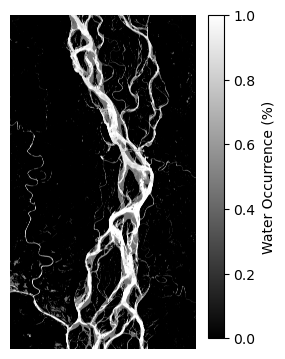

In [22]:
# plot and save water occurance map
import rasterio
from rasterio.transform import from_origin

print(np.shape(all_water_masks))
water_occurrence = np.sum(all_water_masks, axis=2) / all_water_masks.shape[2]

fig, ax = plt.subplots(figsize=(3, 6))


# Display the water occurrence map
im = ax.imshow(water_occurrence, cmap=plt.cm.gray)

# Add the color bar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Water Occurrence (%)')

# Reduce the height of the color bar
cbar.ax.set_position([cbar.ax.get_position().x0,  # x position (no change)
                      cbar.ax.get_position().y0 + 0.125,  # Shift up
                      cbar.ax.get_position().width,   # Keep the width
                      cbar.ax.get_position().height * 0.7])  # Scale height

#ax.set_title('Water Mask Occurrence')
ax.axis('off')
plt.savefig(figdir+'/'+tileID+'/_water_occurence.png')
plt.show()

# Save water occurance to geotiff

# Step 1: Read metadata from the original GeoTIFF
with rasterio.open(water_mask_tiff[0]) as src:
    meta = src.meta.copy()  # Copy the metadata
    transform = src.transform  # Get the transform (geolocation data)
    crs = src.crs  # Get the coordinate reference system

# Step 2: Update metadata for the new GeoTIFF
meta.update({
    'count': 1,  # Single band
    'dtype': 'float32',  # Water occurrence is a float (0.0 to 1.0)
    'driver': 'GTiff'
})

# Step 3: Save the new GeoTIFF
with rasterio.open('D:/work/water_masks/brahmaputra/258_112L/water_occurence_map.tif', 'w', **meta) as dst:
    dst.write(water_occurrence.astype('float32'), 1)  # Write to band 1


In [23]:
## provided a lat/lon coordinate, extract the closest RiverSP node for each time set and plot TS
# Extracting nearest points here (within 1 km away)

from scipy.spatial import cKDTree
from shapely.geometry import Point


def get_nearest_point(riversp_gdf, point_gdf,distance_threshold=1000): # Choosing point nearest in latitude
    # point_gdf == gdf with one geometry entry
    # riversp_gdf == gdf with all nodes of the riversp product
    # both gdf in UTM crs
    # Code developed with support from ChatGPT

    nPoint = np.array(list(point_gdf.geometry.apply(lambda x: (x.x, x.y))))
    nNode = np.array(list(riversp_gdf.geometry.apply(lambda x: (x.x, x.y)))) # build tree based on riversp
    btree = cKDTree(nNode)


    # Find all points within the distance threshold
    indices_within_dist = btree.query_ball_point(nPoint, r=distance_threshold)
    results = []

    for i, indices in enumerate(indices_within_dist):
        if not indices:  # No points within the threshold
            continue

        target_point = nPoint[i]  # The point of interest
        point_lat = target_point[1]  # Latitude of the target point

        # Filter potential nodes and calculate distance and latitude difference
        candidates = riversp_gdf.iloc[indices].copy()
        candidates['dist2Point'] = np.sqrt((candidates.geometry.x - target_point[0])**2 + 
                                           (candidates.geometry.y - target_point[1])**2)
        candidates['lat_diff'] = abs(candidates.geometry.y - point_lat)

        # Sort by latitude difference first, then by geometric distance
        candidates = candidates.sort_values(by=['lat_diff', 'dist2Point'])

        # Take the best match
        results.append(candidates.iloc[0])

    if results:
        return gpd.GeoDataFrame(results, crs=riversp_gdf.crs).reset_index(drop=True)
    else:
        return gpd.GeoDataFrame(columns=riversp_gdf.columns, crs=riversp_gdf.crs)



riversp_gdf = gpd.read_file(odir+'riverSP_out/'+tileID+'/20240203_riverSP.geojson')
# Load in points shapefile

points = gpd.read_file('D:/work/SWOTbraided/qgis/TS_points.shp')
points = points.loc[points.geometry.isna() == False]
points = points.to_crs(riversp_gdf.crs) # put in utm crs matching riversp

ts_points = gpd.GeoDataFrame()

for filename in riverSP_files:

    pixcdate = os.path.basename(filename)[0:8]

    print('Running analysis for ',str(pixcdate))

    # Load RiverSP product
    riversp_gdf = gpd.read_file(odir+'riverSP_out/'+tileID+'/'+pixcdate+'_riverSP.geojson')
    print('reading in file:',odir+'riverSP_out/'+tileID+'/'+pixcdate+'_riverSP.geojson')
    points['heightEGM_med'] = 0

    for id in np.unique(points.id):
        nearest = get_nearest_point(riversp_gdf,points[points.id == id],distance_threshold=1500) 
        print(nearest)



        if len(nearest) > 0:
        
            point_lat = points[points.id == id].get_coordinates().y.iloc[0]
            nearest_lat = nearest.get_coordinates().y.iloc[0]
            if abs(point_lat - nearest_lat) > 400:
                continue
        # # Locate best option (closest lat and dist < 1000)
        # minlat = 1000
        # for row in nearest:
        #     print(row)

        #     lat = row.get_coordinates().y.iloc[0]
        #     if abs(lat - point_lat) < minlat:
        #         idx = 1
        #         #continue
        #     if row.iloc[0].dist2Point > 1500:
        #         continue
            nearest['pixcdate'] = pixcdate
            nearest['pointID'] = id
            ts_points = pd.concat([nearest,ts_points])

            # PLOT SELECTED AND NEAREST POINT TOGETHER

            




ts_points




Running analysis for  20240203
reading in file: D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240203_riverSP.geojson
   heightEGM_med      width  channelID nodeID                       geometry  \
0       4.730057  515.19323         21   2121  POINT (775765.972 2682746.28)   

   dist2Point   lat_diff  
0  174.795929  84.665875  
   heightEGM_med        width  channelID nodeID  \
0       4.714241  1406.393096         22   2222   

                         geometry  dist2Point   lat_diff  
0  POINT (779751.906 2682968.745)  152.130617  60.187951  
   heightEGM_med       width  channelID nodeID                       geometry  \
0       4.469547  652.724906         21    213  POINT (774592.573 2679866.01)   

   dist2Point   lat_diff  
0   80.962592  20.206779  
   heightEGM_med        width  channelID nodeID  \
0       4.507442  2143.712736         22    226   

                         geometry  dist2Point   lat_diff  
0  POINT (780458.258 2680034.365)    240.8863  39.

,heightEGM_med,width,channelID,nodeID,heightEll_med,geoid_med,wf_med,phstd_med,dhdp_med,sig0_med,geometry,dist2Point,lat_diff,pixcdate,pointID
0,10.118139,3184.291818,42,426,-44.391022,-54.508453,0.904865,0.029292,-5.430480,84.049820,POINT (781581.161 2675912.27),86.879650,1.861544,20230910,8
0,9.836391,1451.975934,39,397,-44.729435,-54.571915,0.872516,0.035207,-4.333035,89.393890,POINT (774621.284 2675853.083),693.861914,94.258193,20230910,7
0,10.306057,803.671315,41,4139,-44.169117,-54.474972,0.916096,0.025730,-5.563328,100.852676,POINT (782068.462 2678309.979),794.105532,31.949787,20230910,6
0,10.023743,2015.227254,39,3919,-44.518837,-54.543335,0.921498,0.037029,-4.386541,154.037003,POINT (774749.655 2678188.475),1490.733171,66.652368,20230910,5
0,10.296833,3119.682182,40,407,-44.167343,-54.460346,0.889458,0.031529,-5.511444,84.566223,POINT (781437.18 2679948.098),1217.399603,46.537398,20230910,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,4.165012,317.383724,24,2469,NaN,NaN,NaN,NaN,NaN,NaN,POINT (773261.724 2678146.357),24.569610,24.534552,20240203,5
0,4.507442,2143.712736,22,226,NaN,NaN,NaN,NaN,NaN,NaN,POINT (780458.258 2680034.365),240.886300,39.729202,20240203,4
0,4.469547,652.724906,21,213,NaN,NaN,NaN,NaN,NaN,NaN,POINT (774592.573 2679866.01),80.962592,20.206779,20240203,3
0,4.714241,1406.393096,22,2222,NaN,NaN,NaN,NaN,NaN,NaN,POINT (779751.906 2682968.745),152.130617,60.187951,20240203,2


c:\Users\cwch\Tools\braided_rivers\.pixi\envs\default\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\cwch\Tools\braided_rivers\.pixi\envs\default\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\cwch\Tools\braided_rivers\.pixi\envs\default\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying t

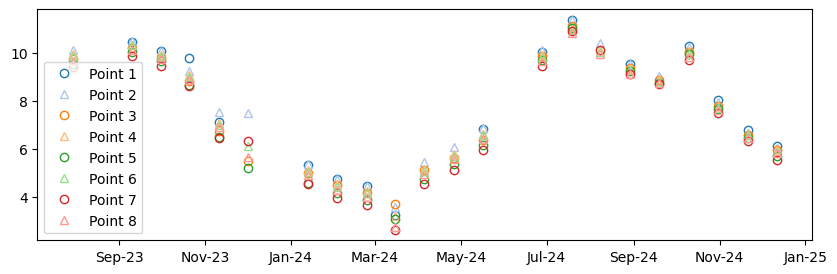

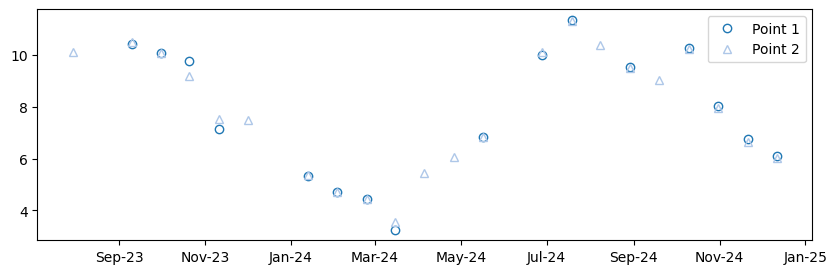

c:\Users\cwch\Tools\braided_rivers\.pixi\envs\default\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\cwch\Tools\braided_rivers\.pixi\envs\default\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


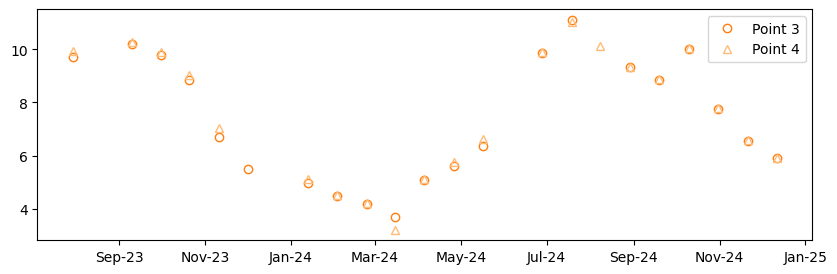

c:\Users\cwch\Tools\braided_rivers\.pixi\envs\default\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\cwch\Tools\braided_rivers\.pixi\envs\default\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


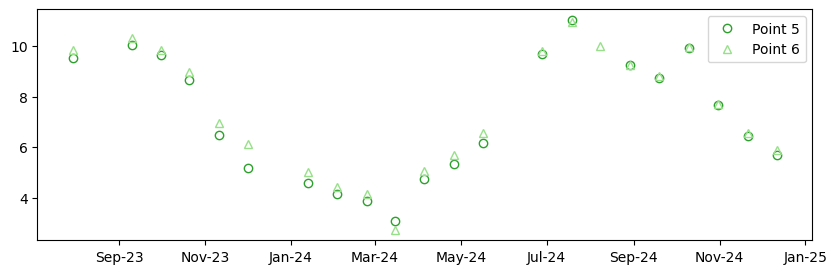

c:\Users\cwch\Tools\braided_rivers\.pixi\envs\default\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\cwch\Tools\braided_rivers\.pixi\envs\default\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


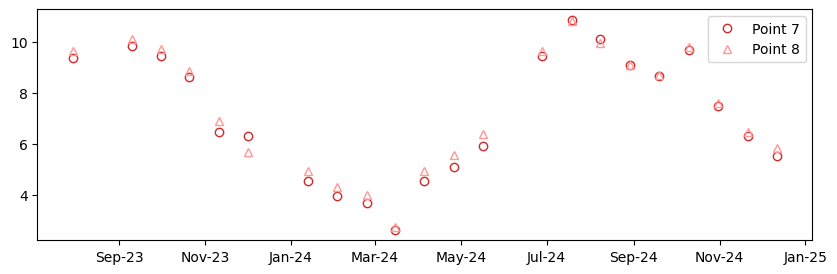

In [24]:
import matplotlib.dates as mdates

cmap = plt.cm.tab20  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

pointpairs = [[1,2],[3,4],[5,6],[7,8]]
markerType = ['o','^','o','^','o','^','o','^','o','^']


fig, ax = plt.subplots(figsize=(10,3))
for pointID in np.unique(ts_points.pointID):

    # extract TS at each point and plot

    sub = ts_points.loc[ts_points.pointID == pointID]
    sub['Date'] = pd.to_datetime(sub['pixcdate'])
    sub = sub.sort_values('Date')

    #fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(sub.Date, sub.heightEGM_med,markerType[pointID-1],label='Point '+str(pointID),markerfacecolor='none', markeredgecolor=cmaplist[pointID-1])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    # ax.set_ylim([2,6])

ax.legend()


for pair in pointpairs:
    fig, ax = plt.subplots(figsize=(10,3))


    sub1 = ts_points.loc[ts_points.pointID == pair[0]]
    sub2 = ts_points.loc[ts_points.pointID == pair[1]]

    # extract TS at each point and plot
    #sub = ts_points.loc[ts_points.pointID == pointID]
    sub1['Date'] = pd.to_datetime(sub1['pixcdate'])
    sub1 = sub1.sort_values('Date')

    sub2['Date'] = pd.to_datetime(sub2['pixcdate'])
    sub2 = sub2.sort_values('Date')

    #fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(sub1.Date, sub1.heightEGM_med,markerType[pair[0]-1],label='Point '+str(pair[0]),markerfacecolor='none', markeredgecolor=cmaplist[pair[0]-1])
    ax.plot(sub2.Date, sub2.heightEGM_med,markerType[pair[1]-1],label='Point '+str(pair[1]),markerfacecolor='none', markeredgecolor=cmaplist[pair[1]-1])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    #ax.set_ylim(2,7)
    #ax.set_xlim(pd.to_datetime('2024-01-01'),pd.to_datetime('2024-06-01'))

    ax.legend()
    plt.show()





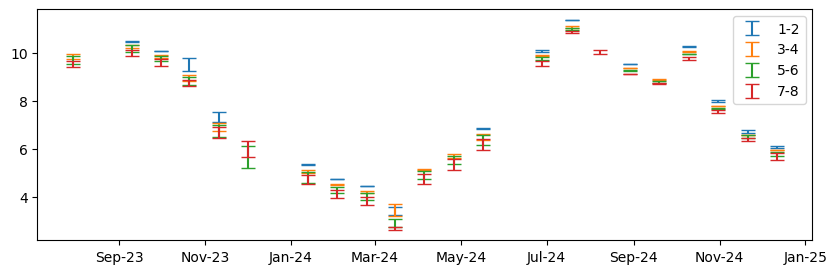

In [25]:
# plotting 'slope' by showing height difference between lower and higher latitude on each channel


# Get differences at each lat
ts_points['Date'] = pd.to_datetime(ts_points['pixcdate'])
ts_points = ts_points.sort_values('Date')

fig, ax = plt.subplots(figsize=(10,3))
i = 1
for pairs in pointpairs:


    sub1 = ts_points[ts_points.pointID == pairs[0]]
    sub2 = ts_points[ts_points.pointID == pairs[1]]

    sub2 = sub2[sub2['Date'].isin(sub1['Date'])]
    sub1 = sub1[sub1['Date'].isin(sub2['Date'])]

    Hdiff = abs(sub2.heightEGM_med - sub1.heightEGM_med)
    Hmean = (sub2.heightEGM_med + sub1.heightEGM_med)/2


    leglabel = str(pairs[0])+'-'+str(pairs[1])

    ax.errorbar(sub2.Date,Hmean,yerr=Hdiff/2,capsize=5.0,c=cmaplist[pairs[0]-1],linestyle='',label=leglabel)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    i = i+1

ax.legend()

pair:  [1, 2]
LF median diff:  0.05840587615966797
HF median diff:  0.052689552307128906
pair:  [3, 4]
LF median diff:  0.09952068328857422
HF median diff:  0.06558990478515625
pair:  [5, 6]
LF median diff:  0.33449745178222656
HF median diff:  0.1131143569946289
pair:  [7, 8]
LF median diff:  0.3826942443847656
HF median diff:  0.14912986755371094


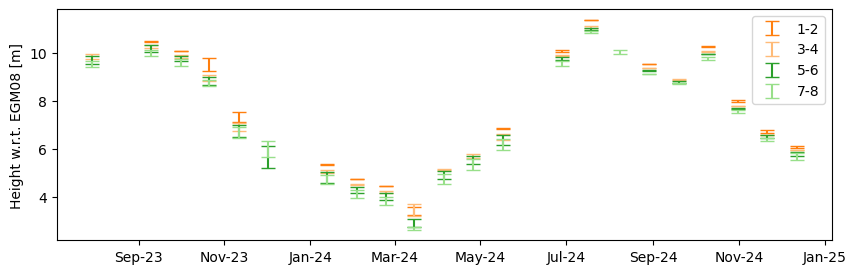

In [26]:

#pointpairs = [[3,7]]

cmap = plt.cm.tab20  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# Get differences at each lat
ts_points['Date'] = pd.to_datetime(ts_points['pixcdate'])
ts_points = ts_points.sort_values('Date')

fig, ax = plt.subplots(figsize=(10,3))
i = 2
for pairs in pointpairs:


    sub1 = ts_points[ts_points.pointID == pairs[0]]
    sub2 = ts_points[ts_points.pointID == pairs[1]]

    sub2 = sub2[sub2['Date'].isin(sub1['Date'])]
    sub1 = sub1[sub1['Date'].isin(sub2['Date'])]


    Hdiff = abs(sub2.heightEGM_med - sub1.heightEGM_med)
    Hmean = (sub2.heightEGM_med + sub1.heightEGM_med)/2
    sub1['hdiff_p1p2'] = Hdiff

    sub1['month'] = sub1['Date'].dt.month
    LFmed = np.nanmedian(sub1[sub1['month'].isin(LFmonths)].hdiff_p1p2)
    HFmed = np.nanmedian(sub1[sub1['month'].isin(HFmonths)].hdiff_p1p2)

    print('pair: ',pairs)
    print('LF median diff: ',LFmed)
    print('HF median diff: ',HFmed)

    leglabel = str(pairs[0])+'-'+str(pairs[1])

    ax.errorbar(sub2.Date,Hmean,yerr=Hdiff/2,capsize=5.0,c=cmaplist[i],linestyle='',label=leglabel)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    ax.set_ylabel('Height w.r.t. EGM08 [m]')
    #ax.set_xlabel('Date')
    i = i+1

ax.legend()
plt.savefig('../figs/'+str(pixcdate)+'_TS.png')

In [27]:
sub1['month'] = sub1['Date'].dt.month
LFmed = np.median(sub1[sub1['month'].isin(LFmonths)].hdiff_p1p2)
HFmed = np.median(sub1[sub1['month'].isin(HFmonths)].hdiff_p1p2)
print('LF median diff: ',LFmed)
print('HF median diff: ',HFmed)



LF median diff:  0.3826942443847656
HF median diff:  0.14912986755371094


In [28]:
HFmonths

[6, 7, 8, 9, 10]

In [29]:
LFmonths

[1, 2, 3, 4, 5, 11, 12]

In [30]:
# # OLD plotting
# # ------------------------------ PLOT selected channels for HF and LF ------------------------------

# # UPDATE to include PIXC points
# # PLot slopes for smaller pieces (ex. set 1.1, set1.2)
# # I2 validation?


# from sklearn.linear_model import LinearRegression

# # LARGE CHANNELS (entire)
# # channel1_dict = dict({'0224':['1','4','8','10','11','12','14','16','17','19','18','22','25','27','28','30','32'],
# #                       '0924':[]})
# # channel2_dict = dict({'0224':[],
# #                       '0924':[]})

# channelSet = 'set1'

# if channelSet == 'set1':
#     # SMALL main CHANNELS (parallel branches)
#     channel1_dict = dict({'0224':['22','25','27','28','30','32'],
#                         '0924':['23','26','28','31','35','41'],
#                         '1024':['24','27','31','34','38']})
#     channel2_dict = dict({'0224':['21','23','24','34','35','38'],
#                         '0924':['22','24','27','37','38','43'],
#                         '1024':['23','25','29','36','41','43']})


# if channelSet == 'set1p1':
#     # SMALL main CHANNELS (parallel branches)
#     channel1_dict = dict({'0224':['22','25'],
#                         '0924':['23','26'],
#                         '1024':['24','27']})
#     channel2_dict = dict({'0224':['21'],
#                         '0924':['22','24'],
#                         '1024':['23','25']})

# if channelSet == 'set2':
#     # SMALLER CHANNELS (divide that merges in HF)
#     channel1_dict = dict({'0224':['14','16'],
#                         '0924':['14','16'],
#                         '1024':['16','18']})
#     channel2_dict = dict({'0224':['13'],
#                         '0924':['14','16'],
#                         '1024':['16','18']})

# if channelSet == 'set3':
#     # Meander and the straight (No1)
#     channel1_dict = dict({'0224':['16','17'],
#                         '0924':['16','17'],
#                         '1024': ['18','19']})
#     channel2_dict = dict({'0224':['15'],
#                         '0924':['15'],
#                         '1024': ['17']})

# if channelSet == 'set4':
#     # Meander and the straight (No2)
#     channel1_dict = dict({'0224':['18','22'],
#                           '0924':['19','29'],
#                           '1024':['21','24']})
#     channel2_dict = dict({'0224':['20'],
#                           '0924':['20','21'],
#                           '1024':['20','22']})

# sel_riverSP = ['D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240203_riverSP.geojson','D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240719_riverSP.geojson']

# #sel_riverSP = ['D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20240203_riverSP.geojson','D:/work/SWOTC/brahmaputra/PIXC/extracted/riverSP_out/258_112L/20241010_riverSP.geojson']


# for filename in sel_riverSP:

#     pixcdate = os.path.basename(filename)[0:8]

#     print('Runnning braided river analysis for:',str(pixcdate))
#     maskdate, water_mask_tiff = pc.getNearestMaskDate(pixcdate, tileID, LFmonths, HFmonths)
#     print('maskdate:',maskdate)


#     # Load RiverSP product
#     riversp_gdf = gpd.read_file(odir+'riverSP_out/'+tileID+'/'+pixcdate+'_riverSP.geojson')
#     print('reading in file:',odir+'riverSP_out/'+tileID+'/'+pixcdate+'_riverSP.geojson')
#     riversp_gdf = riversp_gdf.to_crs('EPSG:4326')

#     # load generated CLs
#     cl_gen = gpd.read_file(odir+tileID+'/'+maskdate+'_generated_cl.geojson')
#     cl_gen = cl_gen.to_crs('EPSG:4326') 
#     sword_cl_gdf = sword_cl_gdf.to_crs('EPSG:4326')

#     # Selected channels
#     ch1 = channel1_dict[maskdate]
#     ch2 = channel2_dict[maskdate]

#     ch1 = list(map(int, ch1))
#     ch2 = list(map(int, ch2))
#     branch_colors = ['green','blue']

#     # prep data for projection along channel cl
#     riversp_gdf['joint_channel_id'] = 0
#     riversp_gdf['dist_jointChannel'] = 0

#     for i in range(2):
#         if i == 0:
#             selChannels_list = ch1
#         if i == 1:
#             selChannels_list = ch2

#         selChannels = selChannels_list #list(map(int, selChannels_list))

#         print('Extracting centerline from cl gdf... (merging and sorting)')
#         # get connected CL
#         idb = cl_gen['branch_id'].isin(selChannels_list)
#         sel_cl = cl_gen.loc[idb]

#         # Fill any gaps in selected centerline and sort reaches by branch id
#         sel_cl = sel_cl.reset_index(drop=True)
#         merged_parts = skel.fill_cl_gaps(sel_cl,hemi,distance_threshold = 1000) # merge all main line parts
#         #print('merged_parts',merged_parts)
#         if isinstance(merged_parts,LineString):
#             merged_line = merged_parts
#         else:
#             merged_line = skel.merge_multiline_with_gaps(merged_parts)   # turns final multilinestring into single linestring and bridges any large gaps between parts

#         merged_line_gdf = gpd.GeoDataFrame(geometry=[merged_line],crs=sel_cl.crs)
#         #print('Plotting joint channel '+str(i+1))
#         #merged_line_gdf.plot()
#         sorted_gdf = merged_line_gdf

#         sorted_gdf = merged_line_gdf
#         if i == 0:
#             merged_line_gdf_ch1 = merged_line_gdf
#         if i == 1:
#             merged_line_gdf_ch2 = merged_line_gdf

#         # OLD VERSION
#         # merged_gdf = fill_cl_gaps(sel_cl,hemi)
#         # sorted_gdf, line_sorted = sort_general_cl(merged_gdf,showPlots=False,reverse=True) # Does this need to be a single line?

#         print('Projecting SWOT RiverSP to joint centerline...')
#         # Select all PIXC data associated with these channels and plot projected to CL
#         idx = riversp_gdf['channelID'].isin(selChannels_list)
#         riversp_gdf.loc[idx, 'joint_channel_id'] = i + 1


#         riversp_gdf.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(merged_line_gdf,riversp_gdf.loc[idx,['geometry']],hemi)
#         #swot_pixc.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(sorted_gdf,swot_pixc.loc[idx,['geometry']],hemi)
#         print('Projected!')
#         #print(riversp_gdf.loc[idx])
#         print('Checking slope...')
#         # CHECK SLOPE - IF NEGATIVE THEN REVERSE DURING 'FILL GAPS'
#         channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] == i + 1]
#         regr = LinearRegression()
#         regr.fit(channels_gdf[['dist_jointChannel']], channels_gdf[['heightEGM_med']])

#         if np.round(regr.coef_[0][0]*1000*100,decimals=4) < 0:
#             # REVERSE CENTERLINE:
#             print('Slope negative! Flipping centerline and re-projecting...')
#             merged_line_gdf = merged_line_gdf.reverse()
#             riversp_gdf.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(merged_line_gdf,riversp_gdf.loc[idx,['geometry']],hemi)
#             print('Projected!')

        
            



#     ## ------------------- Project against SWORD
#     riversp_gdf['dist_SWORDcl'] = pc.projectToCenterline(sword_cl_points,riversp_gdf[['geometry']],hemi)
#     regr_sword = LinearRegression()
#     regr_sword.fit(riversp_gdf[['dist_SWORDcl']], riversp_gdf[['heightEGM_med']])
#     h_pred_sword = regr_sword.predict(riversp_gdf[['dist_SWORDcl']])

#     ## ------------------- PLOT against generated centerline

#     # LOAD PIXC data as well and plot with the riverSP prod...

#     swot_pixc_ch1 = gpd.GeoDataFrame()
#     for channel in ch1:

#         swot_file = odir+'riverSP_out/'+tileID+'/'+pixcdate+'_'+str(channel)+'_subswot.geojson'
#         if os.path.exists(swot_file):
#             # load file and save to swot_pixc
#             print('Reading in SWOT PIXC data....')
#             swot_temp = gpd.read_file(swot_file)
#             # Store
#             swot_pixc_ch1 = pd.concat([swot_pixc_ch1,swot_temp])

#     # project to CL
#     print('Projecting SWOT PIXC data (CH1) to joint centerline...')
#     swot_pixc_ch1['dist_jointCL'] = pc.projectToCenterline(merged_line_gdf_ch1,swot_pixc_ch1[['geometry']],hemi)


#     swot_pixc_ch2 = gpd.GeoDataFrame()
#     for channel in ch2:

#         swot_file = odir+'riverSP_out/'+tileID+'/'+pixcdate+'_'+str(channel)+'_subswot.geojson'
#         if os.path.exists(swot_file):
#             # load file and save to swot_pixc
#             print('Reading in SWOT PIXC data....')
#             swot_temp = gpd.read_file(swot_file)
#             # Store
#             swot_pixc_ch2 = pd.concat([swot_pixc_ch2,swot_temp])
            
#     # project to CL
#     print('Projecting SWOT PIXC data (CH2) to joint centerline...')
#     swot_pixc_ch2['dist_jointCL'] = pc.projectToCenterline(merged_line_gdf_ch2,swot_pixc_ch2[['geometry']],hemi)


#     slopes = []
#     fig, ax = plt.subplots(figsize=(10, 6))
#     ax.scatter(swot_pixc_ch1['dist_jointCL']/1000, swot_pixc_ch1['heightEGM'], alpha=0.4, c='gray', s=0.8, label='PIXC-CH1')
#     ax.scatter(swot_pixc_ch2['dist_jointCL']/1000, swot_pixc_ch2['heightEGM'], alpha=0.4, c='#D3D3D3', s=0.8, label='PIXC-CH2')

#     for joint_channel in np.unique(riversp_gdf['joint_channel_id']):

#         if joint_channel == 0:
#             continue

#         if len(np.unique(riversp_gdf['joint_channel_id'])) == 2: # joint channels are the same...
#             regr = LinearRegression()
#             regr.fit(channels_gdf[['dist_jointChannel']], channels_gdf[['heightEGM_med']])
#             h_pred = regr.predict(channels_gdf[['dist_jointChannel']])
#             print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
#             slopes.append(np.round(regr.coef_[0][0]*1000*100,decimals=4))
#             ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM_med'], alpha=1, c=branch_colors[1], s=2.0, label=str(int(joint_channel)))
#             #ax.plot(channels_gdf.dist_jointChannel/1000, h_pred,'.',markersize=1,c='red')
#             plt.figtext(0.15, 0.83, f'CH. slope = {slopes[0]} cm/km',color=branch_colors[1])
#             break

#         channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] == joint_channel]
#         if joint_channel == 1:
#             medY = np.round(np.median(channels_gdf.heightEGM_med),0)

#         regr = LinearRegression()
#         regr.fit(channels_gdf[['dist_jointChannel']], channels_gdf[['heightEGM_med']])
#         h_pred = regr.predict(channels_gdf[['dist_jointChannel']])
#         print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
#         slopes.append(np.round(regr.coef_[0][0]*1000*100,decimals=4))
#         ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM_med'], alpha=1, c=branch_colors[int(joint_channel-1)], s=2.0, label=str(int(joint_channel)))
#         #ax.plot(channels_gdf.dist_jointChannel/1000, h_pred,'.',markersize=1,c='red')
#         if joint_channel == 1:
#             textH = 0.83
#         else:
#             textH = 0.77
#         plt.figtext(0.15, textH, f'CH. {str(joint_channel)} slope = {slopes[int(joint_channel-1)]} cm/km',color=branch_colors[int(joint_channel-1)])


#     if len(np.unique(riversp_gdf['joint_channel_id'])) != 2:
#         ax.legend(title="Channel",loc='upper center',bbox_to_anchor=(0.9, 0.15),ncol=2, markerscale=5)
#     ax.set_xlabel("Distance along generated centerline [km]")
#     ax.set_ylabel("Height wrt. EGM08 [m]")
#     ax.set_title('Projected along generated centerlines: '+str(pixcdate))
#     # !!!!! USE THESE ONLY ONCE YOU KNOW THE LIMITS FOR SELECTED CLs
#     # ax.set_xlim(0,70)
#     # ax.set_ylim(medY-5,medY+5) # Always keeping window size of 10 m height for better slope comparison

#     # plt.figtext(0.15, 0.83, f'CH. 1 slope = {slopes[0]} cm/km',color=branch_colors[0])
#     # plt.figtext(0.15, 0.77, f'CH. 2 slope = {slopes[1]} cm/km',color=branch_colors[1])
#     plt.figtext(0.15, 0.72, f'SWORD slope = {np.round(regr_sword.coef_[0][0]*1000*100,decimals=4)} cm/km',color='black')
#     plt.savefig('../figs/'+str(pixcdate)+'_slopes_ch_'+channelSet+'.png')
#     #plt.savefig(figdir+'/'+str(pixcdate)+'_projected2jointCL.png')
#     plt.show()


#     # Secondary plots for set1:
#     if channelSet == 'set1' and pixcdate == '20240203':
#         slopes = []
#         fig, ax = plt.subplots(figsize=(10, 6))
#         ax.scatter(swot_pixc_ch1['dist_jointCL']/1000, swot_pixc_ch1['heightEGM'], alpha=0.4, c='gray', s=0.8, label='PIXC-CH1')
#         ax.scatter(swot_pixc_ch2['dist_jointCL']/1000, swot_pixc_ch2['heightEGM'], alpha=0.4, c='#D3D3D3', s=0.8, label='PIXC-CH2')

#         for joint_channel in np.unique(riversp_gdf['joint_channel_id']):

#             if joint_channel == 0:
#                 continue

#             channels_gdf = riversp_gdf[riversp_gdf['joint_channel_id'] == joint_channel]
#             ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM_med'], alpha=1, c=branch_colors[int(joint_channel-1)], s=2.0, label=str(int(joint_channel)))


#             # Slope 1: 
#             subset1 = channels_gdf[channels_gdf['dist_jointChannel'] < 23*1000]
#             regr = LinearRegression()
#             regr.fit(subset1[['dist_jointChannel']], subset1[['heightEGM_med']])
#             h_pred = regr.predict(subset1[['dist_jointChannel']])
#             ax.plot(subset1.dist_jointChannel/1000, h_pred,markersize=1,c='red',alpha=0.5)
#             slope1 = np.round(regr.coef_[0][0]*1000*100,decimals=4)
#             if joint_channel == 1:
#                 ax.text(np.mean(subset1.dist_jointChannel/1000)-3.5,np.mean(h_pred)+0.2,f'Slope = {slope1} cm/km',color='red')
#             else:
#                 ax.text(np.mean(subset1.dist_jointChannel/1000)-0.1,np.mean(h_pred)-0.1,f'Slope = {slope1} cm/km',color='red')


#             # Slope 2
#             subset2 = channels_gdf[channels_gdf['dist_jointChannel'] >= 23*1000]
#             regr = LinearRegression()
#             regr.fit(subset2[['dist_jointChannel']], subset2[['heightEGM_med']])
#             h_pred = regr.predict(subset2[['dist_jointChannel']])
#             ax.plot(subset2.dist_jointChannel/1000, h_pred,markersize=1,c='orange',alpha=0.5)
#             slope2 = np.round(regr.coef_[0][0]*1000*100,decimals=4)
#             if joint_channel == 1:
#                 ax.text(np.mean(subset2.dist_jointChannel/1000)-6,np.mean(h_pred)+0.1,f'Slope = {slope2} cm/km',color='orange')
#             else:
#                 ax.text(np.mean(subset2.dist_jointChannel/1000)-0.1,np.mean(h_pred)-0.1,f'Slope = {slope2} cm/km',color='orange')


#             #print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
#             #ax.plot(channels_gdf.dist_jointChannel/1000, h_pred,'.',markersize=1,c='red')
#             if joint_channel == 1:
#                 textH = 0.83
#             else:
#                 textH = 0.77


#         if len(np.unique(riversp_gdf['joint_channel_id'])) != 2:
#             ax.legend(title="Channel",loc='upper center',bbox_to_anchor=(0.9, 0.15),ncol=2, markerscale=5)
#         ax.set_xlabel("Distance along generated centerline [km]")
#         ax.set_ylabel("Height wrt. EGM08 [m]")
#         ax.set_title('Projected along generated centerlines: '+str(pixcdate))
#         # plt.figtext(0.15, 0.83, f'CH. 1',color='green')
#         # plt.figtext(0.15, 0.77, f'CH. 2',color='blue')
#         plt.figtext(0.15, 0.72, f'SWORD slope = {np.round(regr_sword.coef_[0][0]*1000*100,decimals=4)} cm/km',color='black')
#         plt.savefig('../figs/'+str(pixcdate)+'_slopes_ch_'+channelSet+'_divided.png')
#         plt.show()




#     ## ------------------- PLOT selected cl


#     water_mask = skel.get_watermask(water_mask_tiff)
#     fig, ax = plt.subplots(figsize=(3, 6))

#     # water mask
#     ax.imshow(water_mask, cmap=plt.cm.gray)
    
#     # entire skeleton
#     coords_df = cl_gen.get_coordinates()
#     cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
#     ax.scatter(cl_pixel_coords.x,cl_pixel_coords.y,color='red',s=0.2)
#     # for _, row in cl_gen.iterrows():
#     #     ax.plot(*row.geometry.xy, color='red', linewidth=2)

#     for i in range(2):
#         if i == 0:
#             selChannels_list = ch1
#         if i == 1:
#             selChannels_list = ch2

#         selChannels = selChannels_list 

#         print('Extracting centerline from cl gdf... (merging and sorting)')
#         # get connected CL
#         idb = cl_gen['branch_id'].isin(selChannels_list)
#         sel_cl = cl_gen.loc[idb]

#         # Fill any gaps in selected centerline and sort reaches by branch id
#         sel_cl = sel_cl.reset_index(drop=True)
#         merged_parts = skel.fill_cl_gaps(sel_cl,hemi,distance_threshold = 1000) # merge all main line parts
#         if isinstance(merged_parts,LineString):
#             merged_line = merged_parts
#         else:
#             merged_line = skel.merge_multiline_with_gaps(merged_parts)   # turns final multilinestring into single linestring and bridges any large gaps between parts

#         merged_line_gdf = gpd.GeoDataFrame(geometry=[merged_line],crs=sel_cl.crs)    

#         # get line in  pixel coords
#         coords_df = merged_line_gdf.get_coordinates()
#         merged_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)

#         # for _, row in merged_line_gdf.iterrows():
#         #     ax.plot(*row.geometry.xy, color=branch_colors[int(i)], linewidth=2)

#         # selected channels
#         ax.plot(merged_pixel_coords.x,merged_pixel_coords.y,color=branch_colors[int(i)],linewidth=2)


#     # SWORD CL
#     coords_df = sword_cl_gdf.get_coordinates()
#     sword_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
#     ax.plot(sword_pixel_coords.x,sword_pixel_coords.y,color='yellow',linewidth=2)

#     y, x = np.where((water_mask)) 
#     min_x, max_x = x.min(), x.max()
#     min_y, max_y = y.min(), y.max()
#     ax.set_xlim(min_x, max_x)
#     ax.set_ylim(max_y, min_y)

#     # Set plot properties
#     ax.set_title("Selected centerlines "+str(pixcdate))
#     # Remove x and y tick marks
#     ax.set_xticks([])
#     ax.set_yticks([])

#     plt.savefig('../figs/'+str(pixcdate)+'_selected_channels_'+channelSet+'.png')
#     plt.show()